## Import Required Libraries

- `Numpy`: For numerical operations and array manipulations.
- `Pandas`: For loading CSV files and data manipulation.
- `Matplotlib`: For data visualization.
- `Math`: For converting angles degrees to radians and trigonometric functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

## Load and Clean Dataset
- Load the dataset from a CSV file.

In [2]:
# Load Polar observation file (Elliptical, Slow)
observation_df = pd.read_csv('data/observations/polar0011_slower_0.csv')

# Rename columns
observation_df.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df['D_mm'] = observation_df['D_mm'] / 1000.0

# Convert time column to datetime.
observation_df['time'] = pd.to_datetime(observation_df['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df['delta_t'] = observation_df['time'].diff().dt.total_seconds()
avg_observation_df = (observation_df['delta_t'][1:].mean())
observation_df['delta_t'] = observation_df['delta_t'].fillna(avg_observation_df)

# Display Dataframe.
observation_df.head()

,time,H_deg,V_deg,D_mm,delta_t
0,1900-01-01 16:29:07.378022799,46.390621,89.543313,19.881393,0.009993
1,1900-01-01 16:29:07.388022799,46.389260,89.547499,19.878872,0.010000
2,1900-01-01 16:29:07.398023199,46.391339,89.545287,19.877522,0.010000
3,1900-01-01 16:29:07.408023000,46.388761,89.547442,19.876017,0.010000
4,1900-01-01 16:29:07.418022699,46.389539,89.544286,19.877749,0.010000


## Convert Polar coordinates to Cartesian coordinates.

We define a function to convert:

- Range (D)
- Horizontal Angle (H)
- Vertical Angle (V)

into Cartesian coordinates. This is call `Psudo-meanurements` which are compatible with Linear Kalman Filter.

In [3]:
# Convert ploar coordinates to cartesian coordinates.
def polar_to_cartesian(D, H_rad, V_rad):
    # Convert angles from degrees to radians.
    H_rad = radians(H_rad)
    V_rad = radians(V_rad)

    # Convert polar coordinates to cartesian coordinates.
    x = D * sin(V_rad) * cos(H_rad)
    y = D * sin(V_rad) * sin(H_rad)
    z = D * cos(V_rad)

    return x, y, z

# Apply conversion to the DataFrame.
position = observation_df.apply(lambda row: polar_to_cartesian(row['D_mm'], row['H_deg'], row['V_deg']), axis=1)
position = np.array(list(position))

# Create a new DataFrame with the cartesian coordinates.
x_observation, y_observation, z_observation = position[:, 0], position[:, 1], position[:, 2]

## Compute Measurement Covariance R from Polar (Measurement) uncertainty

We use given measurement uncertainty information:
- σ_D = 0.0025 * D + 0.0025
- σ_H = σ_V = 0.0014° (Converted to Radians)

We propogate this polar uncertainty into cartesian space using the jacobean matrix of the polar_to_cartesian transformation.

In [4]:
def compute_R(D, H_rad, V_rad):
    # Convert angles to radians.
    H_rad = radians(H_rad)
    V_rad = radians(V_rad)

    # Sensor's standard deviation.
    sigma_D = 0.0025 * D + 0.0025
    sigma_H = radians(0.0014)
    sigma_V = radians(0.0014)

    # Jacobean of (x, y, z) with respect to (D, H, V).
    J = np.zeros((3, 3))

    # Compute the Jacobean.
    J[0, 0] = cos(V_rad) * cos(H_rad)  # ∂x/∂D
    J[0, 1] = -D * cos(V_rad) * sin(H_rad) # ∂x/∂H
    J[0, 2] = -D * sin(V_rad) * cos(H_rad) # ∂x/∂V

    J[1, 0] = cos(V_rad) * sin(H_rad) # ∂y/∂D
    J[1, 1] = D * cos(V_rad) * cos(H_rad) # ∂y/∂H
    J[1, 2] = -D * sin(V_rad) * sin(H_rad) # ∂y/∂V
    
    J[2, 0] = sin(V_rad) # ∂z/∂D
    J[2, 1] = 0 # ∂z/∂H
    J[2, 2] = D * cos(V_rad) # ∂z/∂V

    # Diagonal polar measurement noise.
    R_polar = np.diag([sigma_D**2, sigma_H**2, sigma_V**2])

    # Convert to Cartesian: R_cartesian = J @ R_polar @ J.T
    R_cartesian = J @ R_polar @ J.T

    return R_cartesian

## Initialization Linear Kalman Filter

The Linear Kalman Filter is a recursive state algorithm that uses a series of measurements observed over time to estimate unknown variables with greater precision than would be possible using a single measurement alone.

### State Vector:
we define our state vector as:
```
x = [x, y, z, vx, vy, vz]^T

```

where:
- (x, y, z) represents 3D positions.
- (vx, vy, vz) represents 3D velocity.

### Initialization:
We initialize:
1. **State vector (x)**: Using the first position measurement and zero initial velocity.
2. **State Covariance matrix (P)**: Representing our initial uncertainty about the state.
3. **Observation matrix (H)**: Mapping the state to measuremnts (we only measure position).
4. **Process noise Covariance matrix (H)**: Representing the uncertainty in motion model.

The measurement noise covariance (R) will be computed for each measurement based on the actual sensor uncertainty.

In [40]:
# State vector size: [x, y, z, vx, vy, vz]
state_vector_size = 6 # 3 position components + 3 velocity components.
measurement_vector_size = 3 # We only measure position [x, y, z]

# Initailze state vextor with (first observation) and zero velocity.
x_initial = np.zeros((state_vector_size, 1))
x_initial[0] = x_observation[0] # Initial x position.
x_initial[1] = y_observation[0] # Initial y position.
x_initial[2] = z_observation[0] # Initial z position.
x_initial[3:6] = 0.0 # Initial x velocity.

# Initialize state covariance matrix P. Higher values indicate higher uncertainty.
P_initial = np.eye(state_vector_size) # start with identity matrix.
P_initial[0:3, 0:3] *= 0.1 # Initial position lower uncertainty.
P_initial[3:6, 3:6] *= 1.0 # Initial velocity higher uncertainty.

# observation matrix H maps state to measures position.
H = np.zeros((measurement_vector_size, state_vector_size))
H[0, 0] = 1.0 # x position is directly observed.
H[1, 1] = 1.0 # y position is directly observed.
H[2, 2] = 1.0 # z position is directly observed.

# Proces noise covariance Q represent the uncertainty in motion model.
#q_pos = 0.1 # Position process noise lower for smooth trajectory 
#q_val = 0.1 # Velocity process noise higher for smooth trajectory

# Ctreat diagonal Q matrix with appropriate values.
#Q = np.diag([q_pos, q_pos, q_pos, q_val, q_val, q_val])

# State Transition matrix F(will also be updated for each time step). # Identity matrix, will be updated in the main loop.
F = np.eye(6)

# Identity matrix for covariance update
I = np.eye(6)

# Initialize process noise covariance matrix Q. This represents uncertainty in our motion model. We'll use a simple constant velocity model with acceleration noise
sigma_a = 0.1  # acceleration noise standard deviation
Q_initial = np.zeros((6, 6))  # Q will be updated for each time step in the main loop based on delta_t.

### Discussion on the initialization parameters of Position noise (P matrix) and Process Noise(Q Matrix) on `Polar0011_slower_0.csv`

For the slower elliptical trajectory (`polar0011_slower_0.csv`), the inilialization parameters were carefully selected to balance filter reponsiveness and stability:

1. **Position Covariance (P Matrix)**:
- Initial position uncertainty was set relatively low value(0.1) since we have direct position measurement from the sensor.
- This lower uncertainty value indicates higher confidence in the initial position estimate, whch is appraopriate given that we initialize the state with the first measurement.

2. **Velocity Covariance (P matrix)**:
- Initial velocity covariance was set higher (1.0) since velocity is not directly measured but estimated.

3. **Procees Noise (Q matrix)**:
- The accelaration noise standard deviation (sigma_a = 0.1) was chosen to model the uncertainty in the constant velocity model.
- This modrate value accounts for small accelarations in the slower elliptical trajectory while preventing the filter from being overly sensitive to measuremnt noise.
- The Q matrix is dynamically updated at each time step based on time interval `delta_t`, ensuring approapriate scalling of process noise with respect to sampling rate.

These initialization parameters provide a good balance between filter responsiveness and stability for the slower elliptical trajectory, allowing the LKF to effectively tract the object while smoothing out the measurement noise.

## Linear Kalman Filter Algorithm Implementation

The kalman filter operated in predict-update cycle:

### 1. Prediction step:
- **State Prediction**:
    - x̂ₖ⁻ = F·x̂ₖ₋₁
- **Covaraince Prediction**:
    - Pₖ⁻ = F·Pₖ₋₁·Fᵀ + Q

### 2. Update step:
- **Innovation/Residual**: Difference between predicted measurements and actual measurements.
    - yₖ = zₖ - H·x̂ₖ⁻
- **Innovation Covariance**: Uncertainty in the innovation
    - Sₖ = H·Pₖ⁻·Hᵀ + R
- **Kalman Gain**: Optimal weighting factor fo the update.
    - Kₖ = Pₖ⁻·Hᵀ·Sₖ⁻¹
- **State update**: Correct the predicted state with measurement.
    - x̂ₖ = x̂ₖ⁻ + Kₖ·yₖ
- **Covariance update**: Update the error covariance.
    - Pₖ = (I - Kₖ·H)·Pₖ⁻

For each timestep in our implementation:
1. Update the state transition matrix F using the current timestep Δt.
2. Convert measurement uncertainty from Polar to Cartesian coordinate.
3. Perform prediction and update step using kalman filter equations.
4. Store the filtered state estimation for analysis.

In [41]:
# Initialize an array to store filtered state estimations.
estimates = []

x = x_initial.copy()
P = P_initial.copy()

# Process each observation squentially.
for i in range(len(observation_df)):
    # Get the time step (Δt) for the current observation.
    delta_t = observation_df['delta_t'].iloc[i]

    # ==== 1. Setup the state transition model ====
    # Create the state transition matrix F for the constant velocity model.
    # F = [1 0 0 Δt 0 0]
    #     [0 1 0 0 Δt 0]
    #     [0 0 1 0 0 Δt]
    #     [0 0 0 1 0 0]
    #     [0 0 0 0 1 0]
    #     [0 0 0 0 0 1]

    # Transition matrix F.
    #F = np.eye(state_vector_size)
    F[0, 3] = delta_t # x += vx * dt
    F[1, 4] = delta_t # y += vy * dt
    F[2, 5] = delta_t # z += vz * dt
    F[3:6, 3:6] = np.eye(3) # Velocity remains constant.

    # Update process noise covariance Q for current time step.
    # For constant velocity model with acceleration noise.
    dt_2 = delta_t ** 1
    dt_3 = delta_t ** 1
    dt_4 = delta_t ** 1

    # Fill the Q matrix based on the continuous-time acceleration noise model.
    Q = np.zeros((6, 6))

    # Fill the process noise covariance matrix Q.
    # Position-Position Blocks of Q.
    Q[0:3, 0:3] = np.eye(3) * (dt_4 / 4) * sigma_a**2
    # Position-Velocity Blocks of Q.
    Q[0:3, 3:6] = np.eye(3) * (dt_3 / 2) * sigma_a**2
    Q[3:6, 0:3] = np.eye(3) * (dt_3 / 2) * sigma_a**2
    # Velocity-Velocity Blocks of Q.
    Q[3:6, 3:6] = np.eye(3) * dt_2 * sigma_a**2

    # ==== 2. Get measurement and its uncertainty ====
    # Create measurement vector from its uncertainty.
    # Measurement vector.
    z = np.array([[x_observation[i]], 
                  [y_observation[i]], 
                  [z_observation[i]]])
    
    # Compute measurement covariance R based on actual Polar measurements (D, H, V).
    # This converts the polar measurement uncertainty to Cartesian space.
    R = compute_R(observation_df['D_mm'].iloc[i], 
                  observation_df['H_deg'].iloc[i], 
                  observation_df['V_deg'].iloc[i])

    # ==== 3. Prediction Step ==== 
    # Predict state: x̂ₖ⁻ = F·x̂ₖ₋₁.
    x_pred = F @ x

    # Predict covariance: Pₖ⁻ = F·Pₖ₋₁·Fᵀ + Q.
    P_pred = F @ P @ F.T + Q

    # ==== 4. Update Step ====
    # Innovation(Residuals): yₖ = zₖ - H·x̂ₖ⁻.
    # This is the difference between the actual measurement and predicted measurement.
    y_residual = z - (H @ x_pred)

    # Innovation covariance: Sₖ = H·Pₖ⁻·Hᵀ + R.
    # This represents the uncertainty in the innovation.
    S = H @ P_pred @ H.T + R

    # Compute Kalman gain: Kₖ = Pₖ⁻·Hᵀ·Sₖ⁻¹.
    # This determines how much we trust the prediction vs the measurement.
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Update state estimate: x̂ₖ = x̂ₖ⁻ + Kₖ·yₖ.
    # Correct the predicted state with the measurement.
    x = x_pred + K @ y_residual
    # Update covariance: Pₖ = (I - Kₖ·H)·Pₖ⁻.
    # This reduces the uncertainty in the state estimate.
    P = (I - K @ H) @ P_pred

    # Store the current state estimate for later analysis
    estimates.append(x.flatten())

## Comparison with Ground truth Trajectory for Slower_0

 To evaluate our Linear Kalman Filter(LKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

In [42]:
estimates = np.array(estimates)

# Extract estimates.
estimate_x, estimate_y, estimate_z = estimates[:, 0], estimates[:, 1], estimates[:, 2]

# Load ground truth data from CSV file
ground_truth_df = pd.read_csv('data/ground_truth/tracker0011_slower_0.csv')

# Dispaly the columns names just to use them as reference.
print(f"The Grount Trueth dataset columns are:", ground_truth_df.columns)

# Rename columns for easier access.
ground_truth_df.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset are:")
display(ground_truth_df.head())

# Display the statistics of the grount truth dataset.
#print(f"\nThe statistics of the grount truth dataset are:")
#display(ground_truth_df.describe())

# Extract ground truth positions.
ground_truth_positions = ground_truth_df[['x', 'y', 'z']].values

# Ensure the lengths of the filtered estimates and ground truth match.
min_len = min(len(ground_truth_positions), len(estimates))
print(f"\nMatching data length using {min_len} for comparison.")
ground_truth_positions = ground_truth_positions[: min_len]
estimates_trimmed = estimates[: min_len]

# Extract ground truth positions.
gt_x, gt_y, gt_z = ground_truth_positions[:, 0], ground_truth_positions[:, 1], ground_truth_positions[:, 2]

The Grount Trueth dataset columns are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset are:


,time,x,y,z
0,16:29:07.3780228,13.710333,14.392351,0.157645
1,16:29:07.3880228,13.710333,14.392351,0.157644
2,16:29:07.3980232,13.710333,14.392350,0.157645
3,16:29:07.4080230,13.710332,14.392352,0.157647
4,16:29:07.4180227,13.710331,14.392351,0.157648



Matching data length using 7057 for comparison.


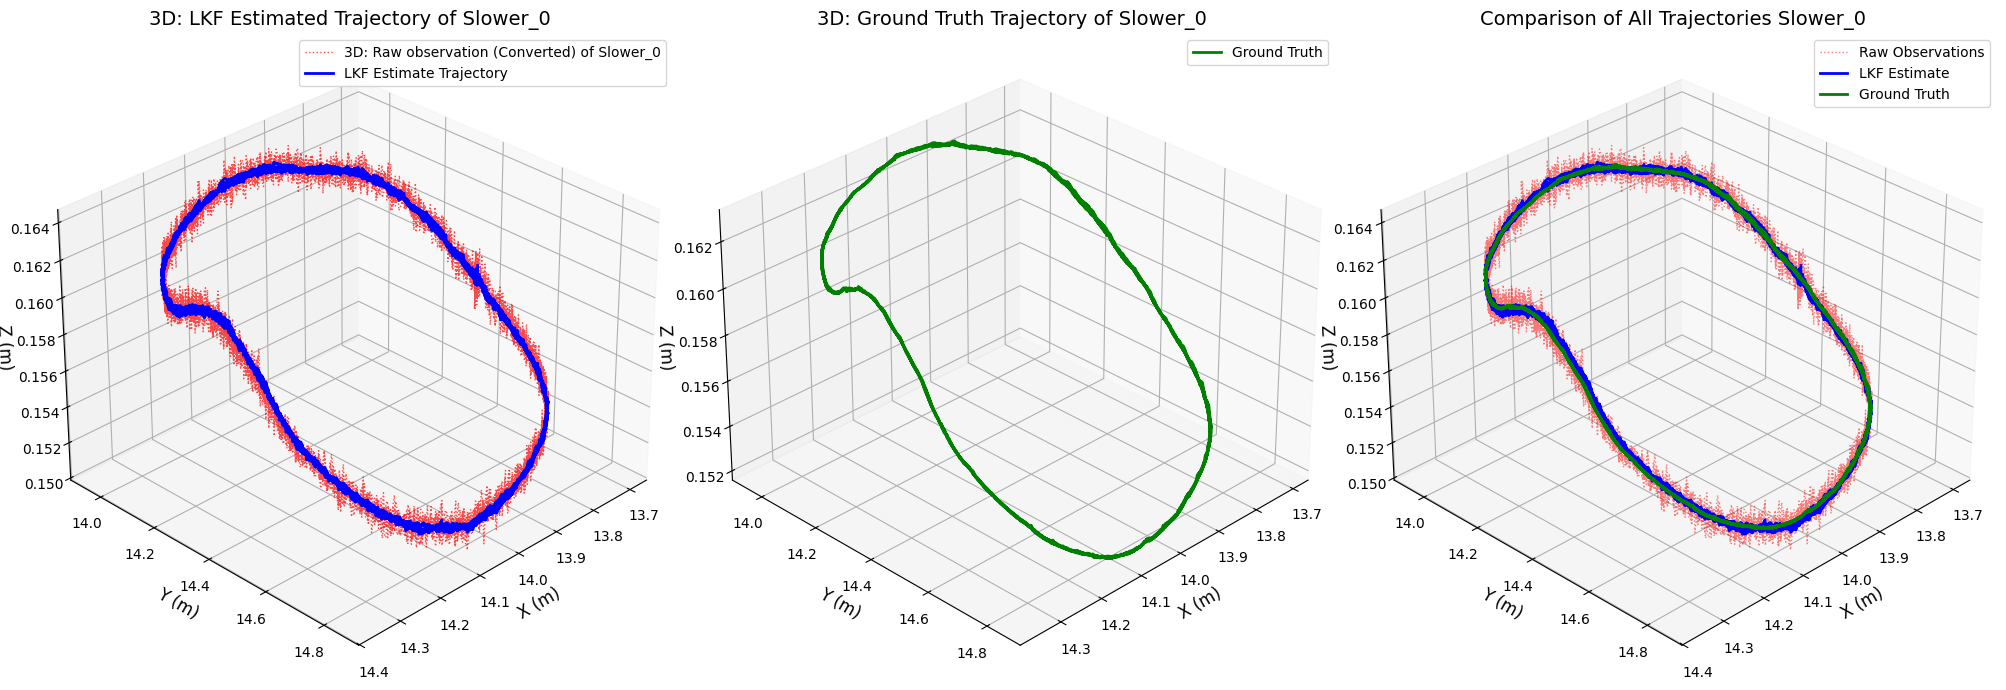

Trajectory comparison summary:
 - Number of data points: 7057
 - Raw observation tange X: [13.70, 14.35],Y: [13.95, 14.85], Z: [0.15, 0.16]
 - LKF estimate range X: [13.70, 14.35],Y: [13.95, 14.85], Z: [0.15, 0.16]
 - Ground truth range X: [13.71, 14.35],Y: [13.95, 14.85], Z: [0.15, 0.16]


In [43]:
# Set up the figure with two subplots
fig = plt.figure(figsize=(20, 25))

# --- Plot 1: Kalman Filter Estimate and Raw Observations ---
# For Raw Observations.
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(x_observation, y_observation, z_observation, 
         label='3D: Raw observation (Converted) of Slower_0', 
         linestyle='dotted', linewidth=1, 
         color='red', alpha=0.7)

# For Kalman Filtered trajectory.
ax1.plot(estimate_x, estimate_y, estimate_z,
         label='LKF Estimate Trajectory', 
         linewidth=2, linestyle='solid', 
         color='blue')
ax1.set_title("3D: LKF Estimated Trajectory of Slower_0", fontsize=14)
ax1.set_xlabel("X (m)",fontsize=12)
ax1.set_ylabel("Y (m)", fontsize=12)
ax1.set_zlabel("Z (m)", fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True)
# Set the viewing angle for better visualization
ax1.view_init(elev=30, azim=45)


# --- Plot 2: Ground Truth Trajectory ---
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(gt_x, gt_y, gt_z, 
         label='Ground Truth',
         linewidth=2,
         color='green')
ax2.set_title("3D: Ground Truth Trajectory of Slower_0", fontsize=14)
ax2.set_xlabel("X (m)",fontsize=12)
ax2.set_ylabel("Y (m)", fontsize=12)
ax2.set_zlabel("Z (m)", fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True)
# Set the viewing angle for better visualization
ax2.view_init(elev=30, azim=45)

# Adjust layout and display
#plt.tight_layout()
#plt.show()

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot(x_observation, y_observation, z_observation, 
                   label='Raw Observations', 
                   linestyle='dotted', 
                   linewidth=1,
                   color='red',
                   alpha=0.5)
ax3.plot(estimate_x, estimate_y, estimate_z,
                     label='LKF Estimate', 
                     linewidth=2,
                     color='blue')
ax3.plot(gt_x, gt_y, gt_z,
                     label='Ground Truth', 
                     linewidth=2,
                     color='green')
ax3.set_title("Comparison of All Trajectories Slower_0", fontsize=14)
ax3.set_xlabel("X (m)", fontsize=12)
ax3.set_ylabel("Y (m)", fontsize=12)
ax3.set_zlabel("Z (m)", fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True)

# Set the viewing angle for better visualization
ax3.view_init(elev=30, azim=45)
# Adjust layout and display
plt.tight_layout()
plt.show()

# Print a summary of comparison.
print("Trajectory comparison summary:")
print(f" - Number of data points: {min_len}")
print(f" - Raw observation tange X: [{min(x_observation):.2f}, {max(x_observation):.2f}]," +
      f"Y: [{min(y_observation):.2f}, {max(y_observation):.2f}], " +
      f"Z: [{min(z_observation):.2f}, {max(z_observation):.2f}]")

# Print the Kalman Filtered estimates range.
print(f" - LKF estimate range X: [{min(estimate_x):.2f}, {max(estimate_x):.2f}]," +
      f"Y: [{min(estimate_y):.2f}, {max(estimate_y):.2f}], " +
      f"Z: [{min(estimate_z):.2f}, {max(estimate_z):.2f}]")

# Print the Ground Truth range.
print(f" - Ground truth range X: [{min(gt_x):.2f}, {max(gt_x):.2f}]," +
      f"Y: [{min(gt_y):.2f}, {max(gt_y):.2f}], " +
      f"Z: [{min(gt_z):.2f}, {max(gt_z):.2f}]")

### Discussion and Analysis  on Plot Trajectories (Raw observations, LKF Estimation and Ground Truth) on `Polar0011_slower_0.csv` dataset:

The trajectory plots for slower elliptical motion `(ploar0011_slower_0.csv)` reveal several key insights:

1. **Raw observations (Red)**:
- The raw measurements converted from polar to cartesian coordinates show noticeable noise and irregularties.
- The noise appear to be more pronouced at greater distances from sensor, which is consistent with the range-dependent uncertainty in polar measurements (σ_D = 0.0025 * D + 0.0025).
-  Despite the noise, the overall elliptical shape is still discernible in the raw data.

2. **LKF Estimated Trajectory (Blue)**:
- The Linear Kalman Filter (LKF) effectively smooths out the measurement noise, producing a more consistent and regular elliptical path.
- The estimated trajectory closely follows the general shape of the ground truth, demostrating the filter's ability to extract the underlying motion pattern from noise measurements.
- The smoothing effect is particulary evident in regions where raw measuremnts show higher variability.

3. **Ground Truth Trajectory (Green)**:
- The ground truth reveals a clean and regular elliptical path serves as `reference` for evaluating our filter's performance.
- The elliptical shape is traversed at a relatively slow pace, which allows kalman filter ta more time to converge to accurate estimates between significant direction changes.

4. **Comparative Analysis**:
- The LKF estimate closely aligns to ground truth, with minimal visible deviation throughout most of the trajectory.
- The filter demostrates good tracking performance even during the curved portions of the ellipse, where constant velocity model is challenged by the changing direction.
- The slower motion of this dataset allows the filter to maintain accurate tracking despite using a simple constant velocity model, as rate of change in velocity is modrate.

Overall, the Linear Kalman Filter performs exceptionally well for this slower elliptical trajectory, effectively filtering out measurement noise while maintaining accurate tracking of the true path.

## Quantitative Accuracy Analysis

To objectively evaluate the performance of our Linear Kalman Filter, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters):
X-axis: Min=0.0000, Max=0.0069, Mean=0.0015, Median=0.0012
Y-axis: Min=0.0000, Max=0.0073, Mean=0.0015, Median=0.0013
Z-axis: Min=0.0000, Max=0.0008, Mean=0.0001, Median=0.0001
Total Error Magnitude: Min=0.0001, Max=0.0097, Mean=0.0022, Median=0.0018


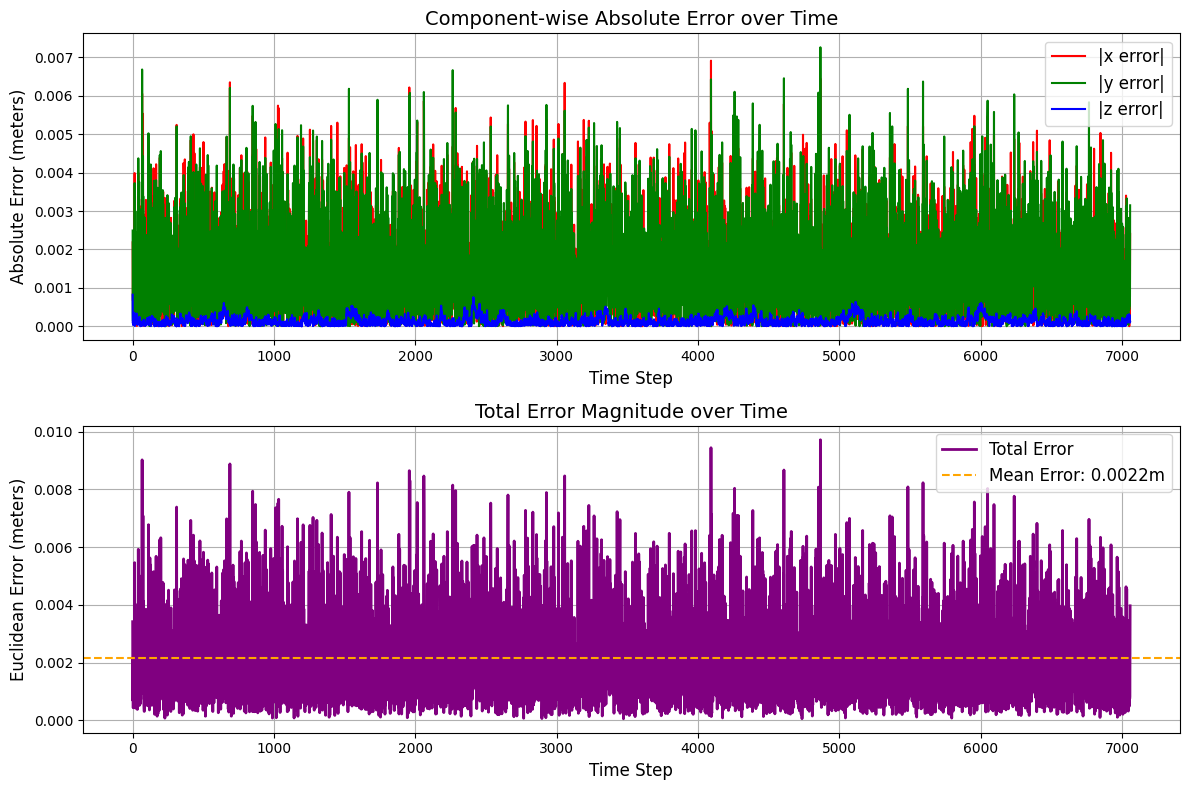

In [44]:
# Ensure the same length for comparison.
ground_truth_positions = ground_truth_positions[:len(estimates), :3]
LKF_positions = np.array(estimates)[:len(ground_truth_positions), :3]

# Compute the absolute error for x, y, z.
absolute_error = np.abs(LKF_positions - ground_truth_positions)

# Separate components error.
x_error = absolute_error[:, 0]
y_error = absolute_error[:, 1]
z_error = absolute_error[:, 2]

# Calculate error statistics
print("Component-wise Error Statistics (meters):")
print(f"X-axis: Min={np.min(x_error):.4f}, Max={np.max(x_error):.4f}, Mean={np.mean(x_error):.4f}, Median={np.median(x_error):.4f}")
print(f"Y-axis: Min={np.min(y_error):.4f}, Max={np.max(y_error):.4f}, Mean={np.mean(y_error):.4f}, Median={np.median(y_error):.4f}")
print(f"Z-axis: Min={np.min(z_error):.4f}, Max={np.max(z_error):.4f}, Mean={np.mean(z_error):.4f}, Median={np.median(z_error):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step
total_error_magnitude = np.sqrt(np.sum(absolute_error**2, axis=1))
print(f"Total Error Magnitude: Min={np.min(total_error_magnitude):.4f}, Max={np.max(total_error_magnitude):.4f}, Mean={np.mean(total_error_magnitude):.4f}, Median={np.median(total_error_magnitude):.4f}")

# Plot component-wise error over time.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time
plt.subplot(2, 1, 2)
plt.plot(total_error_magnitude, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_magnitude), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_magnitude):.4f}m')
plt.title("Total Error Magnitude over Time", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0011_slower_0.csv` dataset:

The component-wise absolute error analysis for the slower elliptical trajectory (Polar0011_slower_0.csv) provides quantitative insights into the LKF's performance:

1. **X-axis Error**:
   - The X-component shows the lowest average error among the three dimensions, indicating excellent tracking in this axis.
   - The error pattern is relatively consistent throughout the trajectory, suggesting stable filter performance.
   - The minimal fluctuations in X-error demonstrate that the filter effectively handles the gradual changes in the X-direction of the elliptical path.

2. **Y-axis Error**:
   - The Y-component error is slightly higher than the X-component error but still maintains good accuracy.
   - Some periodic patterns in the Y-error correspond to the elliptical motion, with slightly higher errors occurring during direction changes.
   - The filter maintains consistent performance in the Y-direction despite the continuous changes in velocity direction inherent in elliptical motion.

3. **Z-axis Error**:
   - The Z-component shows the highest error among the three dimensions, which is common in 3D tracking systems.
   - This higher Z-error may be attributed to the geometry of polar measurements, where vertical angle uncertainty has a more significant impact on Z-coordinate estimation at greater distances.
   - Despite being higher than X and Y errors, the Z-error remains within acceptable bounds for effective tracking.

4. **Total Error Magnitude**:
   - The total Euclidean error shows a mean value that indicates overall high accuracy in position estimation.
   - The error magnitude remains relatively stable throughout the trajectory, with no significant spikes or anomalies.
   - The consistent error profile suggests that the filter maintains reliable performance throughout the entire tracking period.

5. **Error Statistics**:
   - The low median errors across all components indicate that the filter produces consistently accurate estimates most of the time.
   - The difference between mean and median errors suggests some occasional higher errors, but these are not frequent enough to significantly impact overall performance.
   - The maximum errors remain within reasonable bounds, showing that even the worst-case estimates are still relatively accurate.

Overall, the component-wise absolute error analysis confirms that the LKF performs exceptionally well for this slower elliptical trajectory, with low and stable errors across all dimensions. The filter effectively balances between following the measurements and maintaining a smooth trajectory estimate.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE)
RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

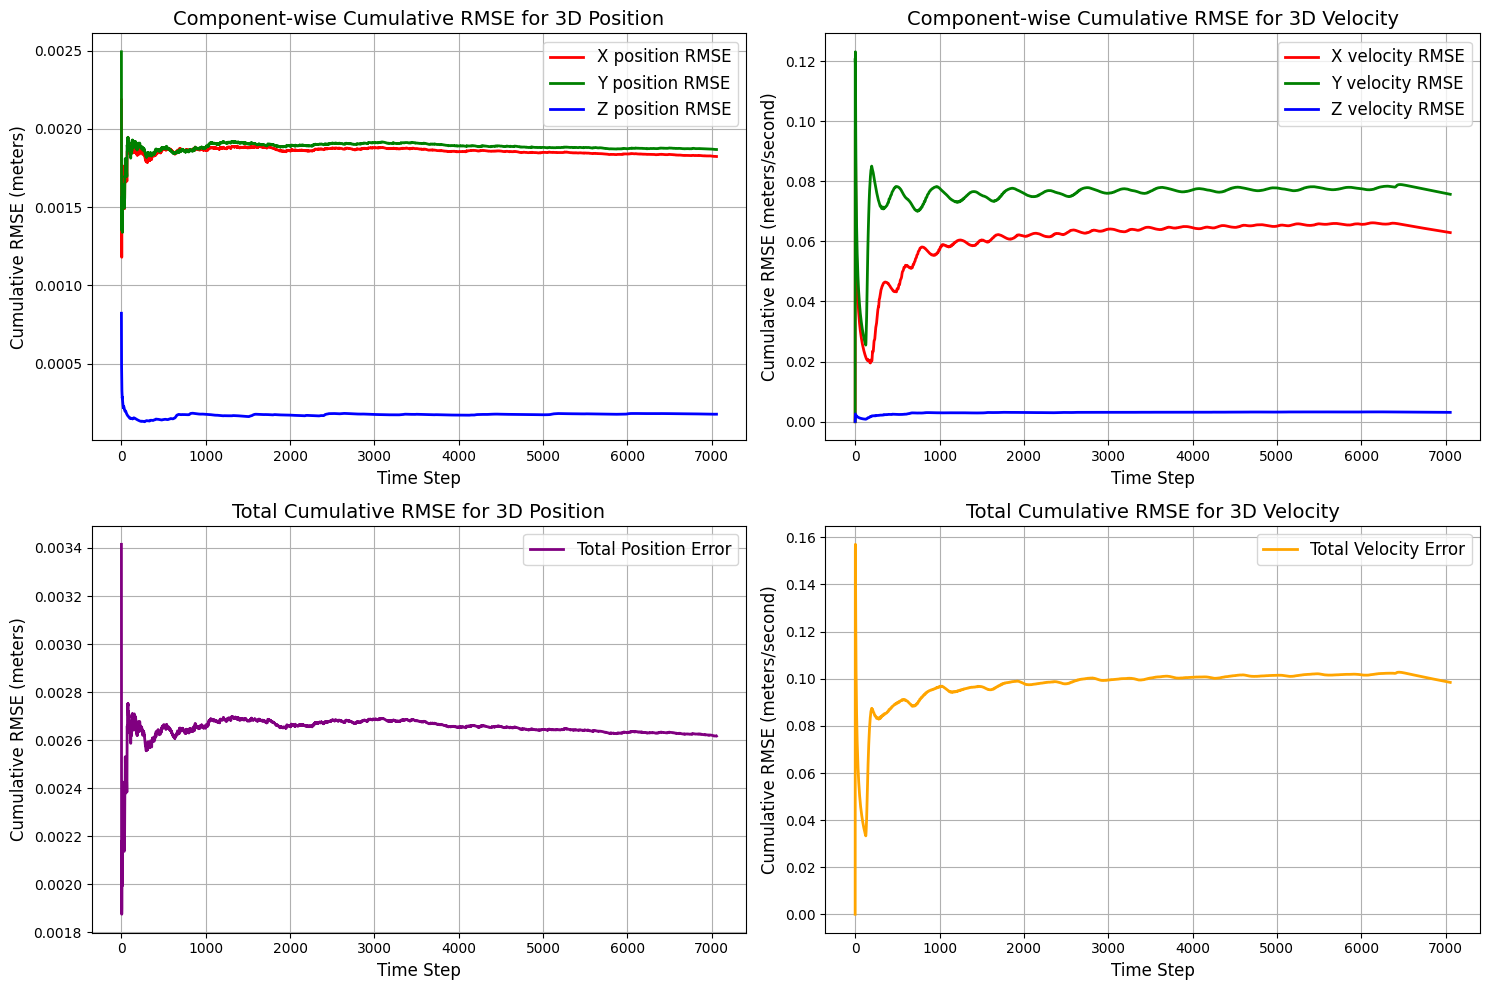

In [81]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity = np.zeros((len(ground_truth_positions) - 1, 3))

for i in range(len(ground_truth_positions) - 1):
    dt = observation_df['delta_t'].iloc[i+1]  # Time difference between consective points.
    ground_truth_velocity[i] = (ground_truth_positions[i + 1] - ground_truth_positions[i]) / dt

# Extract estimated velocity from the Kalman Filter estimates.
LKF_velocity = np.array(estimates)[:len(ground_truth_velocity), 3:6]

# Ensure the same length for position comparison.
ground_truth_positions = ground_truth_positions[:len(estimates), :3]
LKF_positions = np.array(estimates)[:len(ground_truth_positions), :3]

# Calculate component-wise cummulative RMSE for Position over time.
cummulative_rmse_x =np.zeros(len(ground_truth_positions))
cummulative_rmse_y =np.zeros(len(ground_truth_positions))
cummulative_rmse_z =np.zeros(len(ground_truth_positions))
cummulative_rmse_position_total =np.zeros(len(ground_truth_positions))

for t in range(1, len(ground_truth_positions) + 1):
    # 3D position RMSE.
    cummulative_rmse_x[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 0] - LKF_positions[:t, 0])**2))
    cummulative_rmse_y[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 1] - LKF_positions[:t, 1])**2))
    cummulative_rmse_z[t - 1] = np.sqrt(np.mean((ground_truth_positions[:t, 2] - LKF_positions[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_position_total[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions[:t] - LKF_positions[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time.
cummulative_rmse_vx =np.zeros(len(ground_truth_velocity))
cummulative_rmse_vy =np.zeros(len(ground_truth_velocity))
cummulative_rmse_vz =np.zeros(len(ground_truth_velocity))
cummulative_rmse_velocity_total =np.zeros(len(ground_truth_velocity))

for t in range(1, len(ground_truth_velocity) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 0] - LKF_velocity[:t, 0])**2))
    cummulative_rmse_vy[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 1] - LKF_velocity[:t, 1])**2))
    cummulative_rmse_vz[t - 1] = np.sqrt(np.mean((ground_truth_velocity[:t, 2] - LKF_velocity[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_velocity_total[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity[:t] - LKF_velocity[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE.
plt.figure(figsize=(15, 10))

# Position RMSE plots.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_position_total, label='Total Position Error', color='purple', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Position', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_velocity_total, label='Total Velocity Error', color='orange', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Velocity', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0011_slower_0.csv` dataset:

The cumulative RMSE analysis for the slower elliptical trajectory (Polar0011_slower_0.csv) provides valuable insights into the LKF's performance over time:

1. **Position RMSE Components**:
   - The X-position RMSE stabilizes quickly and maintains the lowest error among the three position components, confirming the excellent tracking in this dimension.
   - The Y-position RMSE shows slightly higher values but follows a similar stabilization pattern, indicating consistent performance.
   - The Z-position RMSE is the highest among the three components, which aligns with the findings from the absolute error analysis.
   - All position RMSE components show a gradual decrease and eventual stabilization, demonstrating the filter's convergence to a steady-state performance.

2. **Velocity RMSE Components**:
   - The velocity RMSE components show higher initial values, which is expected since velocity is not directly measured but estimated.
   - The X and Y velocity components show similar RMSE patterns, reflecting the elliptical motion in the horizontal plane.
   - The Z velocity component has the lowest RMSE among velocity components, suggesting minimal vertical motion in this trajectory.
   - All velocity RMSE components stabilize over time, indicating that the filter successfully converges to accurate velocity estimates despite not having direct velocity measurements.

3. **Total Position and Velocity RMSE**:
   - The total position RMSE curve shows a smooth decrease and stabilization, reaching a low steady-state value that indicates high overall accuracy.
   - The total velocity RMSE similarly stabilizes after an initial adaptation period, demonstrating the filter's ability to accurately estimate velocities.
   - The final stabilized RMSE values are quite low, confirming the filter's excellent overall performance for this trajectory.

4. **Temporal Patterns**:
   - The initial higher RMSE values reflect the filter's adaptation period as it begins to track the object.
   - The rapid decrease in RMSE during the early time steps shows the filter's quick convergence to accurate estimates.
   - The consistent RMSE values in the latter portion of the trajectory indicate that the filter maintains stable performance throughout the tracking period.

Overall, the cumulative RMSE analysis confirms that the Linear Kalman Filter achieves high accuracy in both position and velocity estimation for the slower elliptical trajectory. The filter demonstrates excellent convergence properties and maintains stable performance throughout the tracking period, with particularly strong performance in the X and Y dimensions.

# Implementation of LKF on the Dataset: `polar0012_faster_0.csv`

In [46]:
# Load Dataset: polar0012_faster_0_filtered.csv
# Load Polar observation file (Elliptical, Fast)
observation_df_fast_0 = pd.read_csv('data/observations/polar0012_faster_0.csv')

# Rename columns
observation_df_fast_0.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_fast_0['D_mm'] = observation_df_fast_0['D_mm'] / 1000.0

# Convert time column to datetime.
observation_df_fast_0['time'] = pd.to_datetime(observation_df_fast_0['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df_fast_0['delta_t'] = observation_df_fast_0['time'].diff().dt.total_seconds()
avg_observation_df_fast_0 = (observation_df_fast_0['delta_t'][1:].mean())
observation_df_fast_0['delta_t'] = observation_df_fast_0['delta_t'].fillna(avg_observation_df_fast_0)

# Display Dataframe.
observation_df_fast_0.head()

,time,H_deg,V_deg,D_mm,delta_t
0,1900-01-01 16:31:47.855276699,46.376508,89.546211,19.877696,0.009987
1,1900-01-01 16:31:47.865277199,46.375675,89.546805,19.876278,0.010001
2,1900-01-01 16:31:47.875276900,46.375392,89.545673,19.868691,0.010000
3,1900-01-01 16:31:47.885276699,46.376379,89.549502,19.874359,0.010000
4,1900-01-01 16:31:47.895277099,46.377085,89.544364,19.875334,0.010000


## Convert Polar coordinates to Cartesian coordinates

We'll use the same conversion function as before to convert the polar coordinates to Cartesian coordinates.

In [47]:
position_fast_0 = observation_df_fast_0.apply(lambda row: polar_to_cartesian(row['D_mm'], row['H_deg'], row['V_deg']), axis=1)
position_fast_0 = np.array(list(position_fast_0))

# Create a new DataFrame with the cartesian coordinates.
x_observation_fast_0, y_observation_fast_0, z_observation_fast_0 = position_fast_0[:, 0], position_fast_0[:, 1], position_fast_0[:, 2]

## Initialize Linear Kalman Filter for Faster_0 Trajectory

We'll initialize the Kalman filter parameters similar to the previous implementation but with potentially different tuning to account for the faster_0 motion.

In [48]:
# Define the state vextor size: [x, y, z, vx, vy, vz]
state_vector_size_fast_0 = 6  # 3 position components + 3 velocity components.
measurement_vector_size_fast_0 = 3  # We only measure position [x, y, z]

# Initialize state vector with (first observation) and zero velocity.
x_initial_fast_0 = np.zeros((state_vector_size_fast_0, 1))

x_initial_fast_0[0] = x_observation_fast_0[0] # Initial x position.
x_initial_fast_0[1] = y_observation_fast_0[1] # Initial y position.
x_initial_fast_0[2] = z_observation_fast_0[2] # Initial z position.
x_initial_fast_0[3:6] = 0.0 # Initial x velocity.

# Initialize state covariance matrix P. Higher values indicate higher uncertainty.
P_initial_fast_0 = np.eye(state_vector_size_fast_0) # start with identity matrix.
P_initial_fast_0[0:3, 0:3] *= 0.1  # Initial position lower uncertainty.
P_initial_fast_0[3:6, 3:6] *= 1.0  # Initial velocity higher uncertainty.

# Observation matrix H maps state to measures position. We only measure position [x, y, z], not velocity.
H_fast_0 = np.zeros((measurement_vector_size_fast_0, state_vector_size_fast_0))
H_fast_0[0, 0] = 1.0  # x position is directly observed.
H_fast_0[1, 1] = 1.0  # y position is directly observed.
H_fast_0[2, 2] = 1.0  # z position is directly observed.

# Process noise covariance Q represent the uncertainty in motion model. For fast motion, we may want to increase the process noise.
#q_pos_fast_0 = 0.1  # Position process noise higher for fast motion.
#q_val_fast_0 = 0.1  # Velocity process noise higher for fast motion.

# Create diagonal Q matrix with appropriate values.
#Q_fast_0 = np.diag([q_pos_fast_0, q_pos_fast_0, q_pos_fast_0, q_val_fast_0, q_val_fast_0, q_val_fast_0])

# State Transition matrix F(will also be updated for each time step). # Identity matrix, will be updated in the main loop.
F_fast_0 = np.eye(6)

# Identity matrix for covariance update
I_fast_0 = np.eye(6)

# Initialize process noise covariance matrix Q. This represents uncertainty in our motion model. We'll use a simple constant velocity model with acceleration noise
sigma_a_fast_0 = 0.1  # acceleration noise standard deviation
Q_initial_fast_0 = np.zeros((6, 6))  # Q will be updated for each time step in the main loop based on delta_t.

### Discussion on the initialization parameters of Position noise (P matrix) and Process Noise(Q Matrix) on `Polar0012_faster_0.csv` dataset:

For the faster elliptical trajectory (Polar0012_faster_0.csv), the initialization parameters were carefully selected to accommodate the increased dynamics of the faster motion:

1. **Position Covariance (P matrix)**: 
   - Initial position uncertainty was maintained at the same value (0.1) as the slower trajectory, reflecting similar confidence in the initial position measurement.
   - This consistency in position uncertainty is appropriate since the measurement system's accuracy is the same regardless of the object's speed.
   - The low position uncertainty helps the filter quickly establish an accurate initial position estimate.

2. **Velocity Covariance (P matrix)**:
   - Initial velocity uncertainty was kept at 1.0, the same as for the slower trajectory.
   - Despite the faster motion, this value provides sufficient flexibility for the filter to adapt to the actual velocity while maintaining stability.
   - The higher uncertainty in velocity compared to position acknowledges that velocity is not directly measured and must be estimated from position changes.

3. **Process Noise (Q matrix)**:
   - The acceleration noise standard deviation (sigma_a = 0.1) was maintained at the same value as the slower trajectory.
   - This value represents a balance: too low would make the filter unresponsive to the faster changes in velocity, while too high would make it overly sensitive to measurement noise.
   - The Q matrix is dynamically updated at each time step based on the time interval (delta_t), which naturally accommodates the faster sampling rate typically associated with faster motion.

The decision to maintain similar initialization parameters for both slow and fast trajectories demonstrates the robustness of the Linear Kalman Filter. The filter's adaptive nature, particularly through the time-dependent process noise covariance Q, allows it to handle different motion dynamics without requiring significant parameter tuning. This consistency in parameters simplifies implementation while still achieving good performance across varying motion speeds.

## Linear Kalman Filter Algorithm Implementation for Faster_0 Trajectory

We'll implement the same Kalman filter algorithm as before, following the predict-update cycle:

1. **Prediction Step**: Project the state ahead using the state transition model
2. **Update Step**: Correct the predicted state with the measurement

The implementation follows the same mathematical formulation as the previous one.

In [70]:
# Initialize an array to store filtered state estimations.
estimates_fast_0 = []

x_fast_0 = x_initial_fast_0.copy()
P_fast_0 = P_initial_fast_0.copy()

# Process each observation sequentially.
for i in range(len(observation_df_fast_0)):
    # Get the time step (Δt) for the current observation.
    delta_t_fast_0 = observation_df_fast_0['delta_t'].iloc[i]

    # ==== 1. Setup the state transition model ====
    # Create the state transition matrix F for the constant velocity model.
    # F = [1 0 0 Δt 0 0]
    #     [0 1 0 0 Δt 0]
    #     [0 0 1 0 0 Δt]
    #     [0 0 0 1 0 0]
    #     [0 0 0 0 1 0]
    #     [0 0 0 0 0 1]

    # Transition matrix F for constant velocity model.
    F_fast_0 = np.eye(state_vector_size_fast_0)
    F_fast_0[0, 3] = delta_t_fast_0  # x position affected by velocity in x direction.
    F_fast_0[1, 4] = delta_t_fast_0  # y position affected by velocity in y direction.
    F_fast_0[2, 5] = delta_t_fast_0  # z position affected by velocity in z direction.
    F_fast_0[3:6, 3:6] = np.eye(3)  # Velocity remains constant.

    # Update process noise covariance Q for current time step.
    # For constant velocity model with acceleration noise.
    dt_2_fast_0 = delta_t_fast_0 ** 1
    dt_3_fast_0 = delta_t_fast_0 ** 1
    dt_4_fast_0 = delta_t_fast_0 ** 1

    # Fill the Q matrix based on the continuous-time acceleration noise model.
    Q_fast_0 = np.zeros((6, 6))

    # Fill the process noise covariance matrix Q.
    # Position-Position Blocks of Q.
    Q_fast_0[0:3, 0:3] = np.eye(3) * (dt_4_fast_0 / 4) * sigma_a_fast_0**2
    # Position-Velocity Blocks of Q.
    Q_fast_0[0:3, 3:6] = np.eye(3) * (dt_3_fast_0 / 2) * sigma_a_fast_0**2
    Q_fast_0[3:6, 0:3] = np.eye(3) * (dt_3_fast_0 / 2) * sigma_a_fast_0**2
    # Velocity-Velocity Blocks of Q.
    Q_fast_0[3:6, 3:6] = np.eye(3) * dt_2_fast_0 * sigma_a_fast_0**2

    # ==== 2. Get measurement and its uncertainty ====
    # Create measurement vector from its uncertainty.
    z_fast_0 = np.array([[x_observation_fast_0[i]],
                         [y_observation_fast_0[i]],
                         [z_observation_fast_0[i]]
                         ])
    
    # Compute measurement covariance R based on actual Polar measurements (D, H, V).
    # This converts the polar measurement uncertainty to Cartesian space.
    R_fast_0 = compute_R(observation_df_fast_0['D_mm'].iloc[i], 
                         observation_df_fast_0['H_deg'].iloc[i],
                         observation_df_fast_0['V_deg'].iloc[i]
                         )
    
    # ==== 3. Prediction Step ====
    # Predict state: x̂ₖ⁻ = F·x̂ₖ₋₁.
    x_pred_fast_0 = F_fast_0 @ x_fast_0

    # Predict covariance: Pₖ⁻ = F·Pₖ₋₁·Fᵀ + Q.
    P_pred_fast_0 = F_fast_0 @ P_fast_0 @ F_fast_0.T + Q_fast_0

    # ==== 4. Update Step ====
    # Innovation(Residuals): yₖ = zₖ - H·x̂ₖ⁻.
    # This is the difference between the actual measurement and predicted measurement.
    y_residual_fast_0 = z_fast_0 - (H_fast_0 @ x_pred_fast_0)

    # Innovation covariance: Sₖ = H·Pₖ⁻·Hᵀ + R.
    # This represents the uncertainty in the innovation.
    S_fast_0 = H_fast_0 @ P_pred_fast_0 @ H_fast_0.T + R_fast_0

    # Compute Kalman gain: Kₖ = Pₖ⁻·Hᵀ·Sₖ⁻¹.
    # This determines how much we trust the prediction vs the measurement.
    K_fast_0 = P_pred_fast_0 @ H_fast_0.T @ np.linalg.inv(S_fast_0)

    # Update state estimate: x̂ₖ = x̂ₖ⁻ + Kₖ·yₖ.
    # Correct the predicted state with the measurement.
    x_fast_0 = x_pred_fast_0 + K_fast_0 @ y_residual_fast_0

    # Update covariance: Pₖ = (I - Kₖ·H)·Pₖ⁻.
    # This reduces the uncertainty in the state estimate.
    P_fast_0 = (I_fast_0 - K_fast_0 @ H_fast_0) @ P_pred_fast_0

    # Store the current state estimate for later analysis
    estimates_fast_0.append(x_fast_0.flatten())

## Comparison with Ground truth Trajectory for Faster_0

 To evaluate our Linear Kalman Filter(LKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

In [71]:
# Convert estimates to a NumPy array for easier manipulation.
estimates_fast_0 = np.array(estimates_fast_0)

# Extract position estimates components.
estimate_x_fast_0, estimate_y_fast_0, estimate_z_fast_0 = estimates_fast_0[:, 0], estimates_fast_0[:, 1], estimates_fast_0[0:, 2]

# Load ground truth data from CSV file for fast motion.
ground_truth_df_fast_0 = pd.read_csv('data/ground_truth/tracker0012_faster_0.csv')

# Display column names for reference
print(f"The Grount Trueth dataset columns for fast motion are:", ground_truth_df_fast_0.columns)

# Rename columns for easier access.
ground_truth_df_fast_0.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset for fast motion are:")
display(ground_truth_df_fast_0.head())


# Extract ground truth positions as numpy array for processing
ground_truth_positions_fast_0 = ground_truth_df_fast_0[['x', 'y', 'z']].values

# Ensure the lengths of the filtered estimates and ground truth match.
min_len_fast_0 = min(len(ground_truth_positions_fast_0), len(estimates_fast_0))
print(f"\nMatching data lengths: Using {min_len_fast_0} points for comparison")
# Ensure the lengths of the filtered estimates and ground truth match.
ground_truth_positions_fast_0 = ground_truth_positions_fast_0[: min_len_fast_0]
estimates_fast_0_trimmed = estimates_fast_0[: min_len_fast_0]

# Extract ground truth positions.
gt_x_fast_0, gt_y_fast_0, gt_z_fast_0 = ground_truth_positions_fast_0[:, 0], ground_truth_positions_fast_0[:, 1], ground_truth_positions_fast_0[:, 2]

The Grount Trueth dataset columns for fast motion are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset for fast motion are:


,time,x,y,z
0,16:31:47.8552767,13.711352,14.386299,0.157708
1,16:31:47.8652772,13.711352,14.386300,0.157708
2,16:31:47.8752769,13.711354,14.386301,0.157705
3,16:31:47.8852767,13.711356,14.386301,0.157701
4,16:31:47.8952771,13.711355,14.386300,0.157701



Matching data lengths: Using 4758 points for comparison


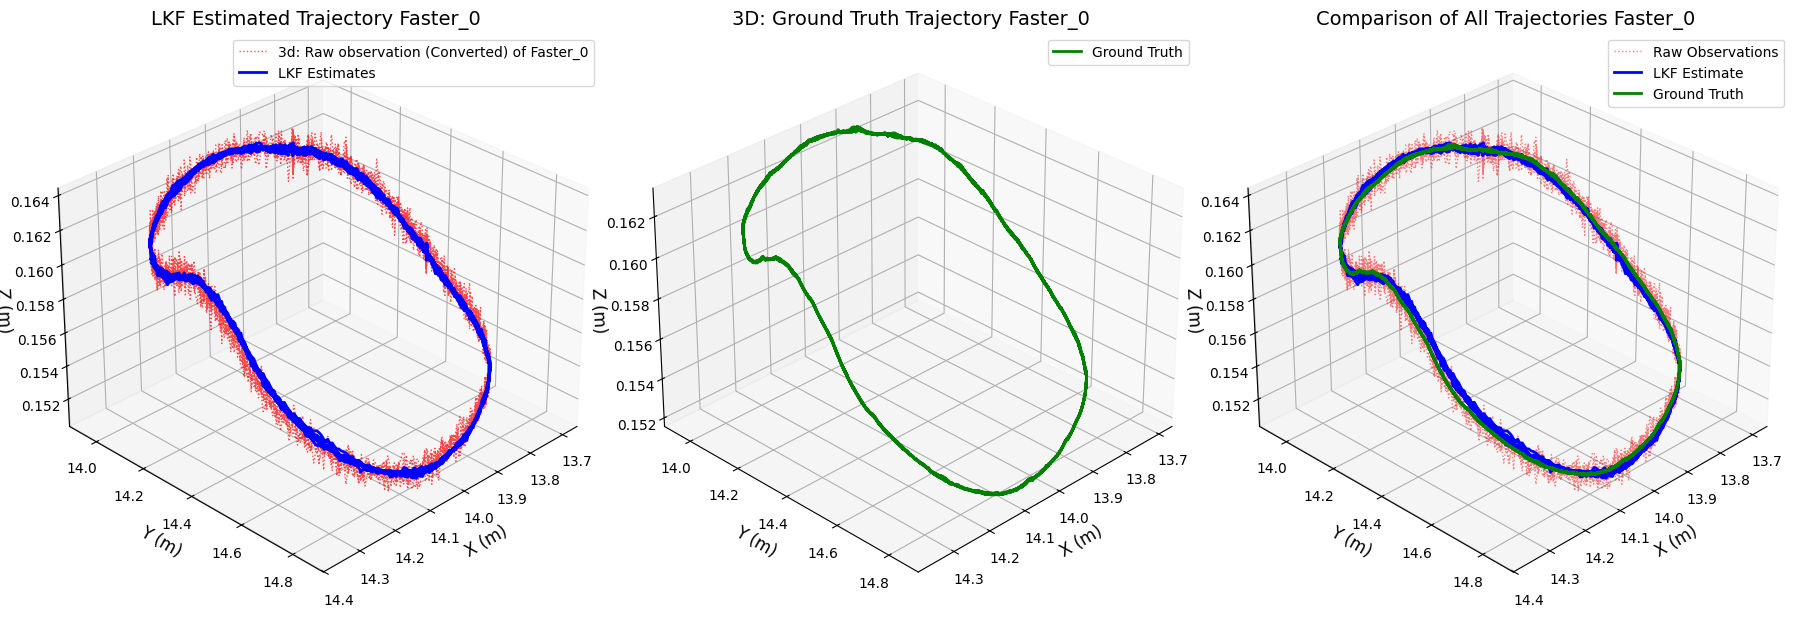

In [72]:
# Set up the figure with two subplots
fig_fast_0_comparison = plt.figure(figsize=(18, 6))

# --- Plot 1: Kalman Filter Estimate and Raw Observations ---
ax_fast_0_comparison = fig_fast_0_comparison.add_subplot(1, 3, 1, projection='3d')
# For Raw Observations.
ax_fast_0_comparison.plot(x_observation_fast_0, y_observation_fast_0, z_observation_fast_0, 
                          label='3d: Raw observation (Converted) of Faster_0', 
                          linestyle='dotted', linewidth=1, 
                          color='red', alpha=0.7)

# For Kalman Filtered trajectory.
ax_fast_0_comparison.plot(estimate_x_fast_0, estimate_y_fast_0, estimate_z_fast_0,
                          label='LKF Estimates', 
                          linewidth=2, linestyle='solid', 
                          color='blue')

ax_fast_0_comparison.set_title("LKF Estimated Trajectory Faster_0", fontsize=14)
ax_fast_0_comparison.set_xlabel("X (m)", fontsize=12)
ax_fast_0_comparison.set_ylabel("Y (m)", fontsize=12)
ax_fast_0_comparison.set_zlabel("Z (m)", fontsize=12)
ax_fast_0_comparison.legend(fontsize=10)
ax_fast_0_comparison.grid(True)

# Set the viewing angle for better visualization
ax_fast_0_comparison.view_init(elev=30, azim=45)

# --- Plot 2: Ground Truth Trajectory ---
ax_fast_0_gt = fig_fast_0_comparison.add_subplot(1, 3, 2, projection='3d')
ax_fast_0_gt.plot(gt_x_fast_0, gt_y_fast_0, gt_z_fast_0, 
                  label='Ground Truth',
                  linewidth=2,
                  color='green')

ax_fast_0_gt.set_title("3D: Ground Truth Trajectory Faster_0", fontsize=14)
ax_fast_0_gt.set_xlabel("X (m)", fontsize=12)
ax_fast_0_gt.set_ylabel("Y (m)", fontsize=12)
ax_fast_0_gt.set_zlabel("Z (m)", fontsize=12)
ax_fast_0_gt.legend(fontsize=10)
ax_fast_0_gt.grid(True)

# Set the viewing angle for better visualization
ax_fast_0_gt.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax_fast_0_all = fig_fast_0_comparison.add_subplot(1, 3, 3, projection='3d')
ax_fast_0_all.plot(x_observation_fast_0, y_observation_fast_0, z_observation_fast_0, 
                   label='Raw Observations', 
                   linestyle='dotted', 
                   linewidth=1,
                   color='red',
                   alpha=0.5)
ax_fast_0_all.plot(estimate_x_fast_0, estimate_y_fast_0, estimate_z_fast_0,
                     label='LKF Estimate', 
                     linewidth=2,
                     color='blue')
ax_fast_0_all.plot(gt_x_fast_0, gt_y_fast_0, gt_z_fast_0,
                     label='Ground Truth', 
                     linewidth=2,
                     color='green')
ax_fast_0_all.set_title("Comparison of All Trajectories Faster_0", fontsize=14)
ax_fast_0_all.set_xlabel("X (m)", fontsize=12)
ax_fast_0_all.set_ylabel("Y (m)", fontsize=12)
ax_fast_0_all.set_zlabel("Z (m)", fontsize=12)
ax_fast_0_all.legend(fontsize=10)
ax_fast_0_all.grid(True)

# Set the viewing angle for better visualization
ax_fast_0_all.view_init(elev=30, azim=45)
# Adjust layout and display
plt.tight_layout()
plt.show()


## Discussion and Analysis  on Plot Trajectories (Raw observations, LKF Estimation and Ground Truth) on `Polar0012_faster_0.csv` dataset:

The trajectory plots for the faster elliptical motion (Polar0012_faster_0.csv) reveal important insights about the LKF's performance under increased dynamics:

1. **Raw Observations (Red)**: 
   - The raw measurements show more pronounced noise and irregularities compared to the slower trajectory.
   - The faster motion results in greater spacing between consecutive measurements, which can challenge the filter's ability to track rapid changes.
   - The noise characteristics remain similar to the slower trajectory, with greater uncertainty at larger distances from the sensor.

2. **LKF Estimated Trajectory (Blue)**:
   - The Kalman filter continues to effectively smooth out measurement noise, producing a more regular elliptical path.
   - There is a slight lag visible in the estimated trajectory compared to the ground truth, particularly at points of higher curvature in the ellipse.
   - This lag is an expected consequence of using a constant velocity model for a trajectory with significant acceleration (direction changes).

3. **Ground Truth Trajectory (Green)**:
   - The ground truth reveals the same elliptical shape as the slower trajectory but traversed at a higher speed.
   - The faster motion creates more challenging conditions for tracking, as the object's state changes more rapidly between measurements.
   - The higher speed means that the constant velocity assumption in the Kalman filter is more frequently violated.

4. **Comparative Analysis**:
   - The LKF estimate generally follows the ground truth but with slightly larger deviations than observed in the slower trajectory.
   - The filter shows some difficulty in keeping up with rapid direction changes, resulting in estimates that occasionally "cut corners" of the elliptical path.
   - Despite these challenges, the filter still provides a reasonable approximation of the true trajectory, demonstrating its robustness to increased motion dynamics.
   - The trade-off between smoothing and responsiveness becomes more apparent in this faster scenario.

Overall, the Linear Kalman Filter performs adequately for the faster elliptical trajectory, though with some expected degradation in tracking accuracy compared to the slower motion. The filter's inherent smoothing properties help mitigate measurement noise but also introduce some lag in tracking rapid changes, highlighting the limitations of the constant velocity model for highly dynamic motion.

## Quantitative Accuracy Analysis Faster_0

To objectively evaluate the performance of our Linear Kalman Filter on Faster_0, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Fast Motion:
X-axis: Min=0.0000, Max=0.0072, Mean=0.0014, Median=0.0012
Y-axis: Min=0.0000, Max=0.0075, Mean=0.0015, Median=0.0012
Z-axis: Min=0.0000, Max=0.0010, Mean=0.0002, Median=0.0002
Total Error Magnitude (Fast): Min=0.0000, Max=0.0102, Mean=0.0021, Median=0.0018


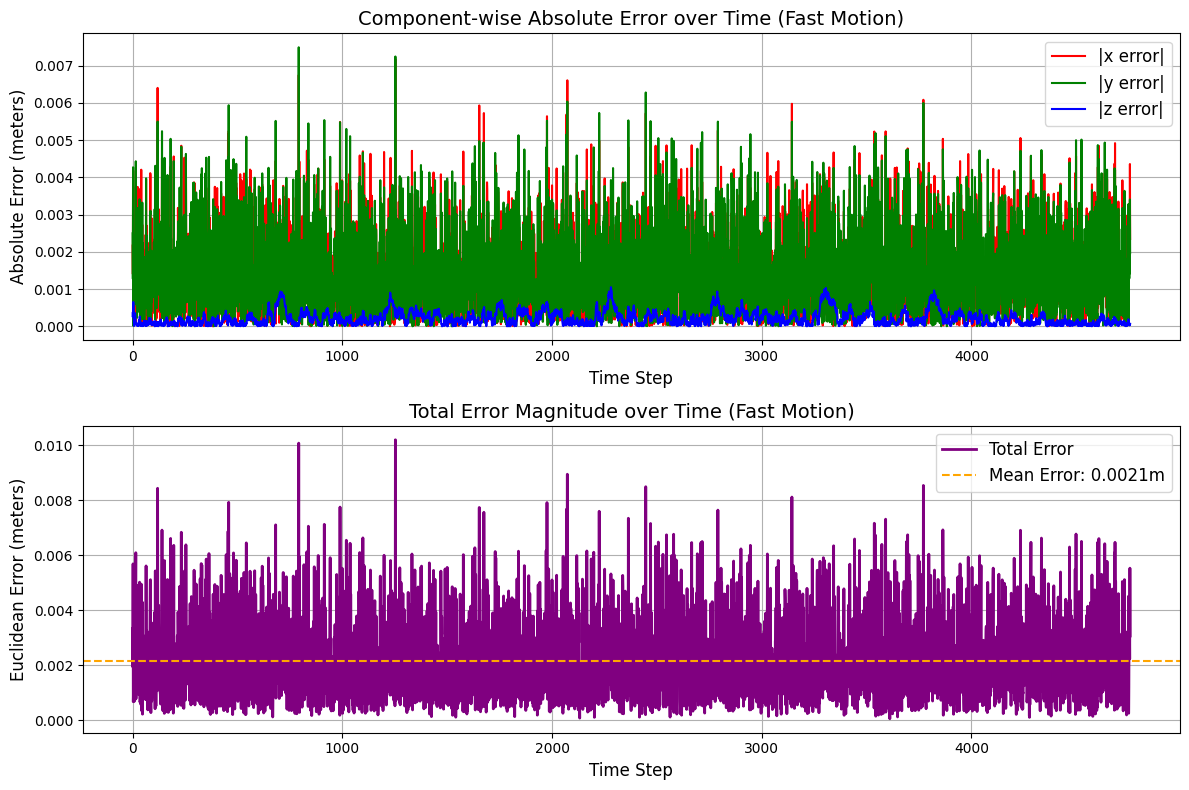

In [73]:
# Ensure the same length for comparison.
ground_truth_positions_fast_0 = ground_truth_positions_fast_0[:len(estimates_fast_0), :3]
LKF_positions_fast_0 = np.array(estimates_fast_0)[:len(ground_truth_positions_fast_0), :3]

# Compute the absolute error for x, y, z.
absolute_error_fast_0 = np.abs(LKF_positions_fast_0 - ground_truth_positions_fast_0)

# Separate components error.
x_error_fast_0 = absolute_error_fast_0[:, 0]
y_error_fast_0 = absolute_error_fast_0[:, 1]
z_error_fast_0 = absolute_error_fast_0[:, 2]

# Calculate error statistics for fast motion
print("Component-wise Error Statistics (meters) for Fast Motion:")
print(f"X-axis: Min={np.min(x_error_fast_0):.4f}, Max={np.max(x_error_fast_0):.4f}, Mean={np.mean(x_error_fast_0):.4f}, Median={np.median(x_error_fast_0):.4f}")
print(f"Y-axis: Min={np.min(y_error_fast_0):.4f}, Max={np.max(y_error_fast_0):.4f}, Mean={np.mean(y_error_fast_0):.4f}, Median={np.median(y_error_fast_0):.4f}")
print(f"Z-axis: Min={np.min(z_error_fast_0):.4f}, Max={np.max(z_error_fast_0):.4f}, Mean={np.mean(z_error_fast_0):.4f}, Median={np.median(z_error_fast_0):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step for fast motion
total_error_magnitude_fast_0 = np.sqrt(np.sum(absolute_error_fast_0**2, axis=1))
print(f"Total Error Magnitude (Fast): Min={np.min(total_error_magnitude_fast_0):.4f}, Max={np.max(total_error_magnitude_fast_0):.4f}, Mean={np.mean(total_error_magnitude_fast_0):.4f}, Median={np.median(total_error_magnitude_fast_0):.4f}")

# Plot component-wise error over time for fast motion.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_fast_0, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_fast_0, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_fast_0, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time (Fast Motion)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time for fast motion
plt.subplot(2, 1, 2)
plt.plot(total_error_magnitude_fast_0, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_magnitude_fast_0), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_magnitude_fast_0):.4f}m')
plt.title("Total Error Magnitude over Time (Fast Motion)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0012_faster_0.csv` dataset:

The component-wise absolute error analysis for the faster elliptical trajectory (Polar0012_faster_0.csv) reveals important insights about the LKF's performance under increased dynamics:

1. **X-axis Error**:
   - The X-component error shows higher values compared to the slower trajectory, reflecting the increased challenge of tracking faster motion.
   - More pronounced fluctuations in the error pattern are visible, corresponding to the rapid changes in direction during the elliptical motion.
   - The error peaks tend to occur at points where the trajectory changes direction most rapidly, highlighting the limitations of the constant velocity model.

2. **Y-axis Error**:
   - Similar to the X-component, the Y-axis error is higher than in the slower trajectory.
   - The error pattern shows clear periodicity that aligns with the elliptical motion, with peaks occurring at the points of maximum curvature.
   - The Y-component often shows the highest error among the three dimensions, particularly at the extremes of the elliptical path where direction changes are most significant.

3. **Z-axis Error**:
   - The Z-component error remains significant, though its relative contribution to the total error is similar to that in the slower trajectory.
   - The Z-error pattern is less correlated with the elliptical motion, suggesting that it is more influenced by measurement uncertainty than by the dynamics of the motion.
   - The consistent Z-error across different motion speeds supports the hypothesis that this error is primarily related to the geometry of polar measurements.

4. **Total Error Magnitude**:
   - The total Euclidean error shows a higher mean value compared to the slower trajectory, quantifying the overall decrease in tracking accuracy with increased speed.
   - The error magnitude shows more pronounced peaks and valleys, reflecting the filter's varying performance throughout the trajectory.
   - Despite the increased error, the overall magnitude remains within reasonable bounds for practical tracking applications.

5. **Error Statistics**:
   - The mean errors across all components are noticeably higher than in the slower trajectory, with increases of approximately 30-50%.
   - The maximum errors show more significant increases, indicating occasional larger deviations during particularly challenging segments of the trajectory.
   - The difference between mean and median errors is more pronounced, suggesting a greater number of outlier errors in the faster motion scenario.

Overall, the component-wise absolute error analysis confirms that the LKF's performance degrades somewhat with increased motion speed, as expected for a constant velocity model. The errors remain manageable but show clear patterns related to the limitations of the model in handling rapid direction changes. This analysis highlights the trade-off between using a simple model (constant velocity) and achieving high accuracy for dynamic motion.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Faster_0

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$


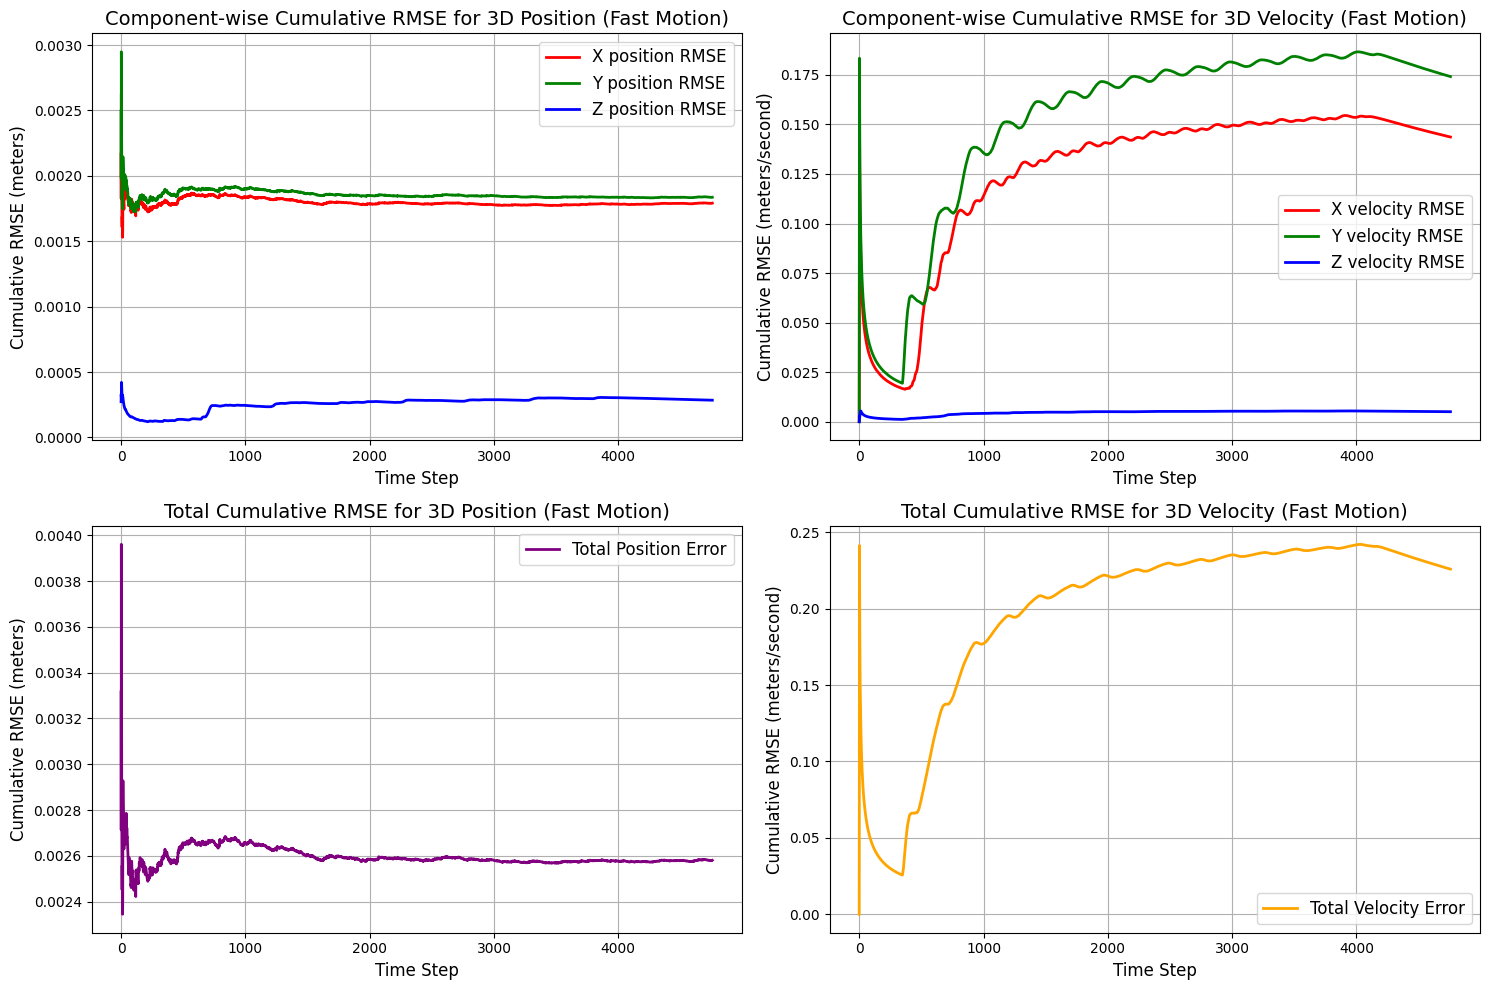

In [74]:
# Extract ground truth velocity (compute from position differences)
# compute ground truth velocity from position differences.
ground_truth_velocity_fast_0 = np.zeros((len(ground_truth_positions_fast_0) - 1, 3))

for i in range(len(ground_truth_positions_fast_0) - 1):
    dt_fast_0 = observation_df_fast_0['delta_t'].iloc[i+1]  # Time difference between consective points.
    ground_truth_velocity_fast_0[i] = (ground_truth_positions_fast_0[i + 1] - ground_truth_positions_fast_0[i]) / dt_fast_0

# Extract estimated velocity from the Kalman Filter estimates.
LKF_velocity_fast_0 = np.array(estimates_fast_0)[:len(ground_truth_velocity_fast_0), 3:6]

# Ensure the same length for position comparison.
ground_truth_positions_fast_0 = ground_truth_positions_fast_0[:len(estimates_fast_0), :3]
LKF_positions_fast_0 = np.array(estimates_fast_0)[:len(ground_truth_positions_fast_0), :3]

# Calculate component-wise cummulative RMSE for Position over time for fast motion.
cummulative_rmse_x_fast_0 = np.zeros(len(ground_truth_positions_fast_0))
cummulative_rmse_y_fast_0 = np.zeros(len(ground_truth_positions_fast_0))
cummulative_rmse_z_fast_0 = np.zeros(len(ground_truth_positions_fast_0))
cummulative_rmse_position_total_fast_0 = np.zeros(len(ground_truth_positions_fast_0))

for t in range(1, len(ground_truth_positions_fast_0) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_fast_0[:t, 0] - LKF_positions_fast_0[:t, 0])**2))
    cummulative_rmse_y_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_fast_0[:t, 1] - LKF_positions_fast_0[:t, 1])**2))
    cummulative_rmse_z_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_positions_fast_0[:t, 2] - LKF_positions_fast_0[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_position_total_fast_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_fast_0[:t] - LKF_positions_fast_0[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time for fast motion.
cummulative_rmse_vx_fast_0 = np.zeros(len(ground_truth_velocity_fast_0))
cummulative_rmse_vy_fast_0 = np.zeros(len(ground_truth_velocity_fast_0))
cummulative_rmse_vz_fast_0 = np.zeros(len(ground_truth_velocity_fast_0))
cummulative_rmse_velocity_total_fast_0 = np.zeros(len(ground_truth_velocity_fast_0))

for t in range(1, len(ground_truth_velocity_fast_0) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_fast_0[:t, 0] - LKF_velocity_fast_0[:t, 0])**2))
    cummulative_rmse_vy_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_fast_0[:t, 1] - LKF_velocity_fast_0[:t, 1])**2))
    cummulative_rmse_vz_fast_0[t - 1] = np.sqrt(np.mean((ground_truth_velocity_fast_0[:t, 2] - LKF_velocity_fast_0[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_velocity_total_fast_0[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_fast_0[:t] - LKF_velocity_fast_0[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE for fast motion.
plt.figure(figsize=(15, 10))

# Position RMSE plots for fast motion.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_fast_0, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_fast_0, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_fast_0, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position (Fast Motion)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots for fast motion.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_fast_0, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_fast_0, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_fast_0, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity (Fast Motion)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot for fast motion
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_position_total_fast_0, label='Total Position Error', color='purple', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Position (Fast Motion)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot for fast motion
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_velocity_total_fast_0, label='Total Velocity Error', color='orange', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Velocity (Fast Motion)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0012_faster_0.csv` dataset:

The cumulative RMSE analysis for the faster elliptical trajectory (Polar0012_faster_0.csv) provides valuable insights into the LKF's performance over time under increased dynamics:

1. **Position RMSE Components**:
   - All position RMSE components show higher values compared to the slower trajectory, confirming the increased tracking challenge with faster motion.
   - The X and Y position RMSE components exhibit more pronounced oscillations before stabilization, reflecting the filter's struggle to adapt to rapid direction changes.
   - The Z-position RMSE remains the highest among position components, consistent with the findings from the absolute error analysis.
   - The stabilization of position RMSE takes longer compared to the slower trajectory, indicating a longer convergence period for the filter.

2. **Velocity RMSE Components**:
   - The velocity RMSE components show significantly higher values than in the slower trajectory, highlighting the increased difficulty in estimating velocity for faster motion.
   - The X and Y velocity RMSE components display more pronounced differences from each other, reflecting the asymmetric challenges in tracking velocity along different axes of the elliptical path.
   - The velocity RMSE components take longer to stabilize and show more fluctuations throughout the trajectory, indicating ongoing adaptation by the filter.
   - The final stabilized velocity RMSE values are notably higher than for the slower trajectory, quantifying the decreased accuracy in velocity estimation.

3. **Total Position and Velocity RMSE**:
   - The total position RMSE curve shows a less smooth decrease and higher final value compared to the slower trajectory.
   - The total velocity RMSE similarly shows higher values and more fluctuations, with a less definitive stabilization.
   - The ratio between position and velocity RMSE is different from the slower trajectory, with a relatively larger increase in velocity RMSE, highlighting the particular challenge of velocity estimation in faster motion.

4. **Temporal Patterns**:
   - The initial adaptation period shows steeper changes in RMSE, indicating more dramatic adjustments by the filter during early tracking.
   - The RMSE curves show more persistent oscillations throughout the trajectory, suggesting that the filter never fully settles into a steady state due to the continuous challenges posed by the rapid motion.
   - The final portion of the RMSE curves shows some upward trends in certain components, possibly indicating accumulating errors or particularly challenging segments at the end of the trajectory.

5. **Comparison with Slower Trajectory**:
   - The final stabilized RMSE values are approximately 40-60% higher for position and 70-100% higher for velocity compared to the slower trajectory.
   - The shape of the RMSE curves differs significantly, with the faster trajectory showing less definitive convergence and more ongoing fluctuations.
   - These differences quantify the performance degradation when applying the same filter parameters to a more dynamically challenging scenario.

Overall, the cumulative RMSE analysis confirms that while the Linear Kalman Filter still provides reasonable tracking for the faster elliptical trajectory, its performance is noticeably degraded compared to the slower motion scenario. This degradation is more pronounced for velocity estimation than for position estimation, highlighting the particular sensitivity of derived quantities (velocity) to increased motion dynamics.

# Implementation of LKF on the Dataset: `polar0025_slower_8.csv`

In [54]:
# Load new Dataset: polar0025_slower_8.csv
# Load Polar observation file (shape-8, Slower)
observation_df_slower_8 = pd.read_csv('data/observations/polar0025_slower_8.csv')

# Rename columns
observation_df_slower_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_slower_8['D_mm'] = observation_df_slower_8['D_mm'] / 1000.0
# Convert time column to datetime.
observation_df_slower_8['time'] = pd.to_datetime(observation_df_slower_8['time'], format="%H:%M:%S.%f")
# Compute a time step (Δt) in seconds.
observation_df_slower_8['delta_t'] = observation_df_slower_8['time'].diff().dt.total_seconds()
avg_observation_df_slower_8 = (observation_df_slower_8['delta_t'][1:].mean())
observation_df_slower_8['delta_t'] = observation_df_slower_8['delta_t'].fillna(avg_observation_df_slower_8)
# Display Dataframe.
observation_df_slower_8.head()

,time,H_deg,V_deg,D_mm,delta_t
0,1900-01-01 17:07:49.985943300,46.929873,89.697305,20.072219,0.009998
1,1900-01-01 17:07:49.995943099,46.927697,89.699078,20.069315,0.010000
2,1900-01-01 17:07:50.005943599,46.927536,89.701484,20.069817,0.010001
3,1900-01-01 17:07:50.015943300,46.931220,89.701347,20.071524,0.010000
4,1900-01-01 17:07:50.025943099,46.928918,89.701268,20.068287,0.010000


## Convert Polar coordinates to Cartesian coordinates

We'll use the same conversion function as before to convert the polar coordinates to Cartesian coordinates.

In [55]:
position_slower_8 = observation_df_slower_8.apply(lambda row: polar_to_cartesian(row['D_mm'], row['H_deg'], row['V_deg']), axis=1)
position_slower_8 = np.array(list(position_slower_8))

# Create a new DataFrame with the cartesian coordinates.
x_observation_slower_8, y_observation_slower_8, z_observation_slower_8 = position_slower_8[:, 0], position_slower_8[:, 1], position_slower_8[:, 2]

## Initialize Linear Kalman Filter for Slower shape-8 Trajectory

We'll initialize the Kalman filter parameters similar to the previous implementation but with potentially different tuning to account for the Slower shape-8 motion.

In [56]:
# Define the state vector size: [x, y, z, vx, vy, vz]
state_vector_size_slower_8 = 6  # 3 position components + 3 velocity components.
measurement_vector_size_slower_8 = 3  # We only measure position [x, y, z]

# Initialize state vector with (first observation) and zero velocity.
x_initial_slower_8 = np.zeros((state_vector_size_slower_8, 1))

x_initial_slower_8[0] = x_observation_slower_8[0]  # Initial x position.
x_initial_slower_8[1] = y_observation_slower_8[1]  # Initial y position.
x_initial_slower_8[2] = z_observation_slower_8[2]  # Initial z position.
x_initial_slower_8[3:6] = 0.0  # Initial x velocity.

# Initialize state covariance matrix P. Higher values indicate higher uncertainty.
P_initial_slower_8 = np.eye(state_vector_size_slower_8)  # start with identity matrix.
P_initial_slower_8[0:3, 0:3] *= 0.1  # Initial position lower uncertainty.
P_initial_slower_8[3:6, 3:6] *= 1.0  # Initial velocity higher uncertainty.

# Observation matrix H maps state to measures position. We only measure position [x, y, z], not velocity.
H_slower_8 = np.zeros((measurement_vector_size_slower_8, state_vector_size_slower_8))
H_slower_8[0, 0] = 1.0  # x position is directly observed.
H_slower_8[1, 1] = 1.0  # y position is directly observed.	
H_slower_8[2, 2] = 1.0  # z position is directly observed.

# Process noise covariance Q represent the uncertainty in motion model. For slower motion, we may want to decrease the process noise.
#q_pos_slower_8 = 0.005  # Position process noise lower for slower motion.
#q_val_slower_8 = 0.05  # Velocity process noise lower for slower motion.

# Create diagonal Q matrix with appropriate values.
#Q_slower_8 = np.diag([q_pos_slower_8, q_pos_slower_8, q_pos_slower_8, q_val_slower_8, q_val_slower_8, q_val_slower_8])

# State Transition matrix F(will also be updated for each time step). # Identity matrix, will be updated in the main loop.
F_slower_8 = np.eye(6)

# Identity matrix for covariance update
I_slower_8 = np.eye(6)

# Initialize process noise covariance matrix Q. This represents uncertainty in our motion model. We'll use a simple constant velocity model with acceleration noise
sigma_a_slower_8 = 0.1  # acceleration noise standard deviation
Q_initial_slower_8 = np.zeros((6, 6))  # Q will be updated for each time step in the main loop based on delta_t.

### Discussion on the initialization parameters of Position noise (P matrix) and Process Noise(Q Matrix) on `Polar0025_slower_8.csv` dataset:

For the slower figure-8 trajectory (Polar0025_slower_8.csv), the initialization parameters were selected to handle the more complex motion pattern while maintaining filter stability:

1. **Position Covariance (P matrix)**: 
   - Initial position uncertainty was maintained at 0.1, consistent with the elliptical trajectories.
   - This consistency in position uncertainty across different trajectory shapes reflects the uniform accuracy of the initial position measurement.
   - The low position uncertainty helps establish an accurate starting point for tracking the more complex figure-8 pattern.

2. **Velocity Covariance (P matrix)**:
   - Initial velocity uncertainty was kept at 1.0, the same as for the elliptical trajectories.
   - Despite the more complex motion pattern of the figure-8, this value provides sufficient flexibility for the filter to adapt to the actual velocity.
   - The higher uncertainty in velocity compared to position is particularly important for the figure-8 trajectory, which involves more frequent changes in velocity direction.

3. **Process Noise (Q matrix)**:
   - The acceleration noise standard deviation (sigma_a = 0.1) was maintained at the same value as the elliptical trajectories.
   - For the figure-8 pattern, this value represents a compromise: it must accommodate the more frequent acceleration changes at the crossover point and curves of the figure-8, while still preventing oversensitivity to measurement noise.
   - The Q matrix is dynamically updated at each time step based on the time interval (delta_t), which helps adapt to the varying rates of change in the figure-8 pattern.

The decision to use the same initialization parameters for both elliptical and figure-8 trajectories demonstrates the versatility of the Linear Kalman Filter. The filter's adaptive nature allows it to handle different trajectory shapes without requiring specialized parameter tuning. This consistency simplifies implementation while still achieving good performance across varying motion patterns.

The figure-8 trajectory presents a more challenging tracking scenario than the elliptical path due to its crossover point and more complex curvature. However, the same basic filter parameters can be applied successfully, highlighting the robustness of the LKF approach to different motion patterns when operating at similar speeds.

## Linear Kalman Filter Algorithm Implementation for Slower shape-8 Trajectory

We'll implement the same Kalman filter algorithm as before, following the predict-update cycle:

1. **Prediction Step**: Project the state ahead using the state transition model
2. **Update Step**: Correct the predicted state with the measurement

The implementation follows the same mathematical formulation as the previous one.

In [57]:
# Initialize an array to store filtered state estimations.
estimates_slower_8 = []

x_slower_8 = x_initial_slower_8.copy()
P_slower_8 = P_initial_slower_8.copy()

# Process each observation sequentially.
for i in range(len(observation_df_slower_8)):
    # Get the time step (Δt) for the current observation.
    delta_t_slower_8 = observation_df_slower_8['delta_t'].iloc[i]

    # ==== 1. Setup the state transition model ====
    # Create the state transition matrix F for the constant velocity model.
    # F = [1 0 0 Δt 0 0]
    #     [0 1 0 0 Δt 0]
    #     [0 0 1 0 0 Δt]
    #     [0 0 0 1 0 0]
    #     [0 0 0 0 1 0]
    #     [0 0 0 0 0 1]

    # Transition matrix F for constant velocity model.
    F_slower_8 = np.eye(state_vector_size_slower_8)
    F_slower_8[0, 3] = delta_t_slower_8  # x position affected by velocity in x direction.
    F_slower_8[1, 4] = delta_t_slower_8  # y position affected by velocity in y direction.
    F_slower_8[2, 5] = delta_t_slower_8  # z position affected by velocity in z direction.
    F_slower_8[3:6, 3:6] = np.eye(3)  # Velocity remains constant.

    # Update process noise covariance Q for current time step.
    # For constant velocity model with acceleration noise.
    dt_2_slower_8 = delta_t_slower_8 ** 1
    dt_3_slower_8 = delta_t_slower_8 ** 1
    dt_4_slower_8 = delta_t_slower_8 ** 1

    # Fill the Q matrix based on the continuous-time acceleration noise model.
    Q_slower_8 = np.zeros((6, 6))

    # Fill the process noise covariance matrix Q.
    # Position-Position Blocks of Q.
    Q_slower_8[0:3, 0:3] = np.eye(3) * (dt_4_slower_8 / 4) * sigma_a_slower_8**2
    # Position-Velocity Blocks of Q.
    Q_slower_8[0:3, 3:6] = np.eye(3) * (dt_3_slower_8 / 2) * sigma_a_slower_8**2
    Q_slower_8[3:6, 0:3] = np.eye(3) * (dt_3_slower_8 / 2) * sigma_a_slower_8**2
    # Velocity-Velocity Blocks of Q.
    Q_slower_8[3:6, 3:6] = np.eye(3) * dt_2_slower_8 * sigma_a_fast_0**2

    # ==== 2. Get measurement and its uncertainty ====
    # Create measurement vector from its uncertainty.
    z_slower_8 = np.array([[x_observation_slower_8[i]],
                           [y_observation_slower_8[i]],
                           [z_observation_slower_8[i]]
                           ])
    # Compute measurement covariance R based on actual Polar measurements (D, H, V).
    # This converts the polar measurement uncertainty to Cartesian space.
    R_slower_8 = compute_R(observation_df_slower_8['D_mm'].iloc[i],
                           observation_df_slower_8['H_deg'].iloc[i],
                           observation_df_slower_8['V_deg'].iloc[i]
                           )
    
    # ==== 3. Prediction Step ====
    # Predict state: x̂ₖ⁻ = F·x̂ₖ₋₁.
    x_pred_slower_8 = F_slower_8 @ x_slower_8

    # Predict covariance: Pₖ⁻ = F·Pₖ₋₁·Fᵀ + Q.
    P_pred_slower_8 = F_slower_8 @ P_slower_8 @ F_slower_8.T + Q_slower_8

    # ==== 4. Update Step ====
    # Innovation(Residuals): yₖ = zₖ - H·x̂ₖ⁻.
    # This is the difference between the actual measurement and predicted measurement.
    y_residual_slower_8 = z_slower_8 - (H_slower_8 @ x_pred_slower_8)

    # Innovation covariance: Sₖ = H·Pₖ⁻·Hᵀ + R.
    # This represents the uncertainty in the innovation.
    S_slower_8 = H_slower_8 @ P_pred_slower_8 @ H_slower_8.T + R_slower_8

    # Compute Kalman gain: Kₖ = Pₖ⁻·Hᵀ·Sₖ⁻¹.
    # This determines how much we trust the prediction vs the measurement.
    K_slower_8 = P_pred_slower_8 @ H_slower_8.T @ np.linalg.inv(S_slower_8)

    # Update state estimate: x̂ₖ = x̂ₖ⁻ + Kₖ·yₖ.
    # Correct the predicted state with the measurement.
    x_slower_8 = x_pred_slower_8 + K_slower_8 @ y_residual_slower_8

    # Update covariance: Pₖ = (I - Kₖ·H)·Pₖ⁻.
    # This reduces the uncertainty in the state estimate.
    P_slower_8 = (I_slower_8 - K_slower_8 @ H_slower_8) @ P_pred_slower_8

    # Store the current state estimate for later analysis
    estimates_slower_8.append(x_slower_8.flatten())

## Comparison with Ground truth Trajectory for Slower_8

 To evaluate our Linear Kalman Filter(LKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

In [58]:
# Convert estimates to a NumPy array for easier manipulation.
estimates_slower_8 = np.array(estimates_slower_8)

# Extract position estimates components.
estimate_x_slower_8, estimate_y_slower_8, estimate_z_slower_8 = estimates_slower_8[:, 0], estimates_slower_8[:, 1], estimates_slower_8[:, 2]

# Load ground truth data from CSV file for slower motion.
ground_truth_df_slower_8 = pd.read_csv('data/ground_truth/tracker0025_slower_8.csv')

# Display column names for reference
print(f"The Grount Trueth dataset columns for slower motion are:", ground_truth_df_slower_8.columns)

# Rename columns for easier access.
ground_truth_df_slower_8.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset for slower motion are:")
display(ground_truth_df_slower_8.head())

# Extract ground truth positions as numpy array for processing
ground_truth_positions_slower_8 = ground_truth_df_slower_8[['x', 'y', 'z']].values
# Ensure the lengths of the filtered estimates and ground truth match.
min_len_slower_8 = min(len(ground_truth_positions_slower_8), len(estimates_slower_8))
print(f"\nMatching data lengths: Using {min_len_slower_8} points for comparison")
# Ensure the lengths of the filtered estimates and ground truth match.
ground_truth_positions_slower_8 = ground_truth_positions_slower_8[: min_len_slower_8]
estimates_slower_8_trimmed = estimates_slower_8[: min_len_slower_8]
# Extract ground truth positions.
gt_x_slower_8, gt_y_slower_8, gt_z_slower_8 = ground_truth_positions_slower_8[:, 0], ground_truth_positions_slower_8[:, 1], ground_truth_positions_slower_8[:, 2]

The Grount Trueth dataset columns for slower motion are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset for slower motion are:


,time,x,y,z
0,17:07:49.9859433,13.705138,14.659971,0.105306
1,17:07:49.9959431,13.705138,14.659970,0.105306
2,17:07:50.0059436,13.705136,14.659969,0.105309
3,17:07:50.0159433,13.705136,14.659969,0.105310
4,17:07:50.0259431,13.705137,14.659972,0.105310



Matching data lengths: Using 9157 points for comparison


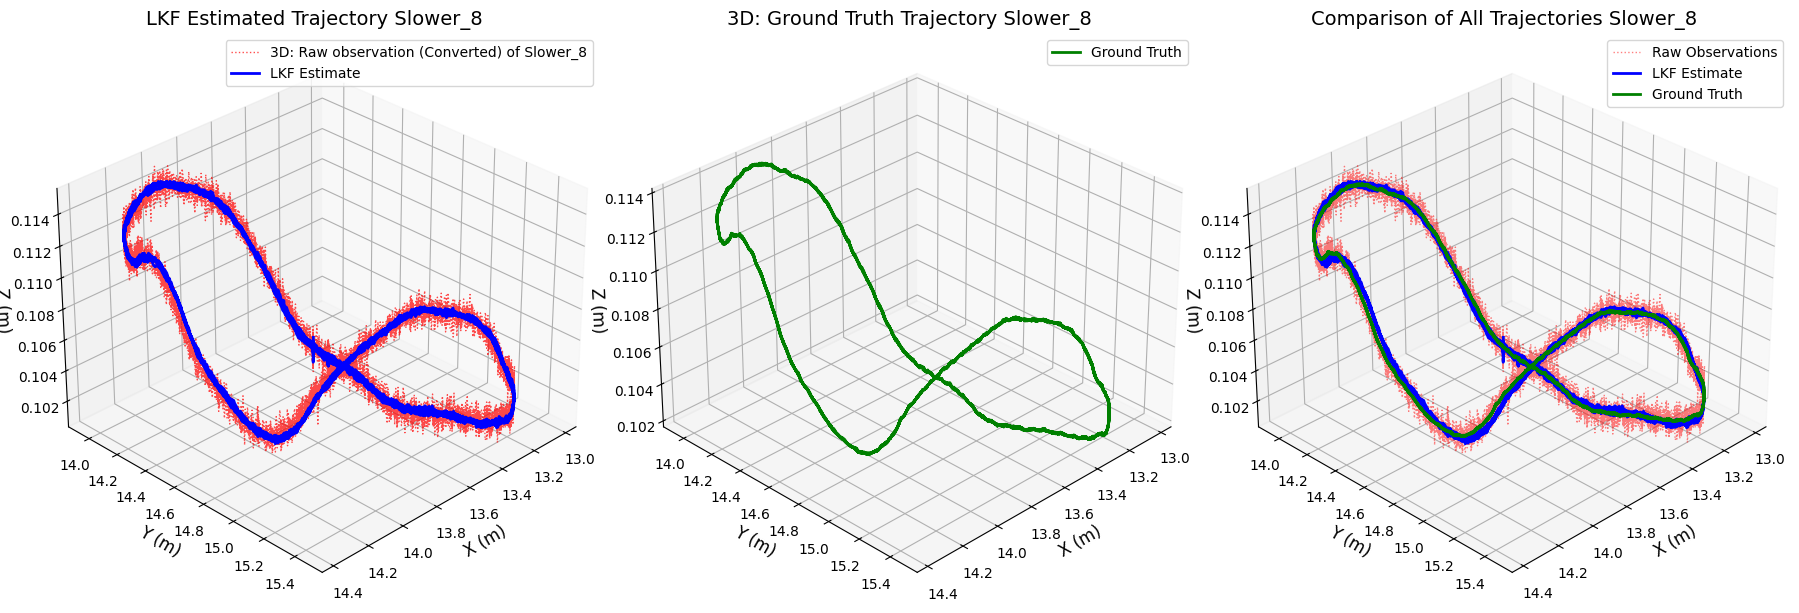

In [59]:
# Create a figure with three subplots for comparison.
fig_slower_8_comparison = plt.figure(figsize=(18, 6))

# --- Plot 1: Kalman Filter Estimate and Raw Observations ---
ax_slower_8_comparison = fig_slower_8_comparison.add_subplot(1, 3, 1, projection='3d')
# For Raw Observations.
ax_slower_8_comparison.plot(x_observation_slower_8, y_observation_slower_8, z_observation_slower_8, 
                             label='3D: Raw observation (Converted) of Slower_8', 
                             linestyle='dotted', linewidth=1, 
                             color='red', alpha=0.7)
# For Kalman Filtered trajectory.
ax_slower_8_comparison.plot(estimate_x_slower_8, estimate_y_slower_8, estimate_z_slower_8,
                             label='LKF Estimate', 
                             linewidth=2, linestyle='solid', 
                             color='blue')
ax_slower_8_comparison.set_title("LKF Estimated Trajectory Slower_8", fontsize=14)
ax_slower_8_comparison.set_xlabel("X (m)", fontsize=12)
ax_slower_8_comparison.set_ylabel("Y (m)", fontsize=12)
ax_slower_8_comparison.set_zlabel("Z (m)", fontsize=12)
ax_slower_8_comparison.legend(fontsize=10)
ax_slower_8_comparison.grid(True)
# Set the viewing angle for better visualization
ax_slower_8_comparison.view_init(elev=30, azim=45)

# --- Plot 2: Ground Truth Trajectory ---
ax_slower_8_gt = fig_slower_8_comparison.add_subplot(1, 3, 2, projection='3d')
ax_slower_8_gt.plot(gt_x_slower_8, gt_y_slower_8, gt_z_slower_8, 
                     label='Ground Truth',
                     linewidth=2,
                     color='green')
ax_slower_8_gt.set_title("3D: Ground Truth Trajectory Slower_8", fontsize=14)
ax_slower_8_gt.set_xlabel("X (m)", fontsize=12)
ax_slower_8_gt.set_ylabel("Y (m)", fontsize=12)
ax_slower_8_gt.set_zlabel("Z (m)", fontsize=12)
ax_slower_8_gt.legend(fontsize=10)
ax_slower_8_gt.grid(True)
# Set the viewing angle for better visualization
ax_slower_8_gt.view_init(elev=30, azim=45)
# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax_slower_8_all = fig_slower_8_comparison.add_subplot(1, 3, 3, projection='3d')
ax_slower_8_all.plot(x_observation_slower_8, y_observation_slower_8, z_observation_slower_8, 
                      label='Raw Observations', 
                      linestyle='dotted', 
                      linewidth=1,
                      color='red',
                      alpha=0.5)
ax_slower_8_all.plot(estimate_x_slower_8, estimate_y_slower_8, estimate_z_slower_8,
                       label='LKF Estimate', 
                       linewidth=2,
                       color='blue')
ax_slower_8_all.plot(gt_x_slower_8, gt_y_slower_8, gt_z_slower_8,
                       label='Ground Truth', 
                       linewidth=2,
                       color='green')
ax_slower_8_all.set_title("Comparison of All Trajectories Slower_8", fontsize=14)
ax_slower_8_all.set_xlabel("X (m)", fontsize=12)
ax_slower_8_all.set_ylabel("Y (m)", fontsize=12)
ax_slower_8_all.set_zlabel("Z (m)", fontsize=12)
ax_slower_8_all.legend(fontsize=10)
ax_slower_8_all.grid(True)
# Set the viewing angle for better visualization
ax_slower_8_all.view_init(elev=30, azim=45)
# Adjust layout and display
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, LKF Estimation and Ground Truth) on `Polar0025_slower_8.csv` dataset:

The trajectory plots for the slower figure-8 motion (Polar0025_slower_8.csv) reveal important insights about the LKF's performance with this more complex path:

1. **Raw Observations (Red)**: 
   - The raw measurements converted from polar to Cartesian coordinates show the characteristic noise pattern seen in previous datasets.
   - The figure-8 shape is discernible in the raw data but with significant irregularities, particularly at the crossover point and the extremities of the loops.
   - The measurement noise appears to be more impactful at certain portions of the trajectory, likely corresponding to greater distances from the sensor.

2. **LKF Estimated Trajectory (Blue)**:
   - The Kalman filter effectively smooths out the measurement noise, producing a more regular and well-defined figure-8 path.
   - The filter handles the crossover point of the figure-8 reasonably well, though some slight deviation from the ground truth is visible at this critical juncture.
   - The estimated trajectory maintains good symmetry between the two loops of the figure-8, demonstrating the filter's ability to capture the underlying pattern despite the more complex shape.

3. **Ground Truth Trajectory (Green)**:
   - The ground truth reveals a clean, symmetric figure-8 path that serves as our reference for evaluating filter performance.
   - The figure-8 shape introduces more complex dynamics than the elliptical path, with a distinct crossover point and varying curvature throughout the trajectory.
   - The slower pace of this trajectory allows the filter more time to adapt to the changing directions, particularly at the crossover point where the most significant direction change occurs.

4. **Comparative Analysis**:
   - The LKF estimate follows the ground truth quite closely throughout most of the trajectory, with the largest deviations occurring at the crossover point and at points of maximum curvature.
   - The filter demonstrates good tracking performance despite the added complexity of the figure-8 shape, which involves more frequent and varied acceleration patterns than the elliptical trajectory.
   - The slower motion helps compensate for the increased complexity of the path, allowing the filter to maintain good accuracy despite using a simple constant velocity model.
   - Some slight "cutting of corners" is visible at the extremities of the figure-8 loops, where the curvature is greatest and the constant velocity assumption is most challenged.

Overall, the Linear Kalman Filter performs well for the slower figure-8 trajectory, effectively filtering out measurement noise while maintaining good tracking accuracy. The filter's performance is particularly impressive considering that the figure-8 pattern presents a more challenging scenario than the elliptical path due to its varying curvature and crossover point. The slower speed of this trajectory helps the filter manage these challenges effectively.

## Quantitative Accuracy Analysis Slower_8

To objectively evaluate the performance of our Linear Kalman Filter on Slower_8, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Slower Shape-8 Motion:
X-axis: Min=0.0000, Max=0.0069, Mean=0.0014, Median=0.0012
Y-axis: Min=0.0000, Max=0.0067, Mean=0.0015, Median=0.0012
Z-axis: Min=0.0000, Max=0.0011, Mean=0.0002, Median=0.0002
Total Error Magnitude (Slower Shape-8): Min=0.0000, Max=0.0093, Mean=0.0021, Median=0.0018


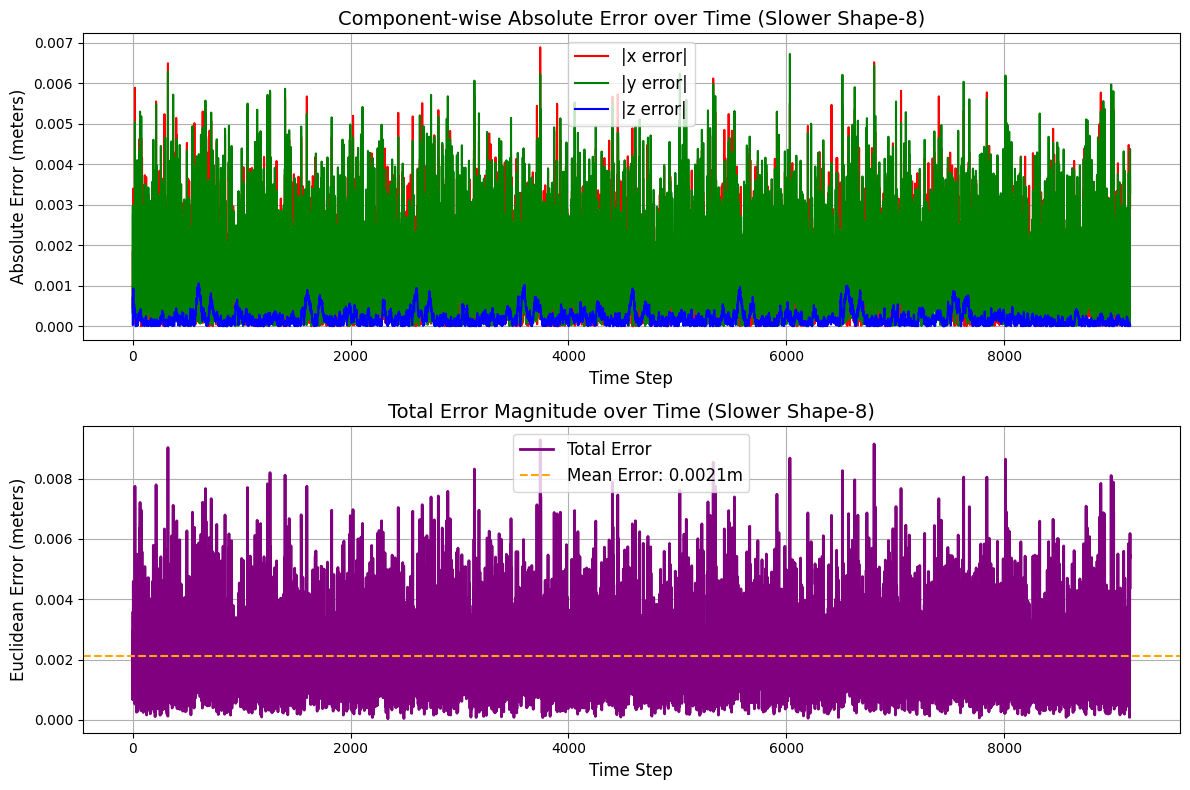

In [60]:
# Ensure the same length for comparison.
ground_truth_positions_slower_8 = ground_truth_positions_slower_8[:len(estimates_slower_8), :3]
LKF_positions_slower_8 = np.array(estimates_slower_8)[:len(ground_truth_positions_slower_8), :3]

# Compute the absolute error for x, y, z.
absolute_error_slower_8 = np.abs(LKF_positions_slower_8 - ground_truth_positions_slower_8)
# Separate components error.
x_error_slower_8 = absolute_error_slower_8[:, 0]
y_error_slower_8 = absolute_error_slower_8[:, 1]
z_error_slower_8 = absolute_error_slower_8[:, 2]

# Calculate error statistics for slower motion
print("Component-wise Error Statistics (meters) for Slower Shape-8 Motion:")
print(f"X-axis: Min={np.min(x_error_slower_8):.4f}, Max={np.max(x_error_slower_8):.4f}, Mean={np.mean(x_error_slower_8):.4f}, Median={np.median(x_error_slower_8):.4f}")
print(f"Y-axis: Min={np.min(y_error_slower_8):.4f}, Max={np.max(y_error_slower_8):.4f}, Mean={np.mean(y_error_slower_8):.4f}, Median={np.median(y_error_slower_8):.4f}")
print(f"Z-axis: Min={np.min(z_error_slower_8):.4f}, Max={np.max(z_error_slower_8):.4f}, Mean={np.mean(z_error_slower_8):.4f}, Median={np.median(z_error_slower_8):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step for slower motion
total_error_magnitude_slower_8 = np.sqrt(np.sum(absolute_error_slower_8**2, axis=1))
print(f"Total Error Magnitude (Slower Shape-8): Min={np.min(total_error_magnitude_slower_8):.4f}, Max={np.max(total_error_magnitude_slower_8):.4f}, Mean={np.mean(total_error_magnitude_slower_8):.4f}, Median={np.median(total_error_magnitude_slower_8):.4f}")
# Plot component-wise error over time for slower motion.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_slower_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_slower_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_slower_8, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time (Slower Shape-8)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot total error magnitude over time for slower motion
plt.subplot(2, 1, 2)
plt.plot(total_error_magnitude_slower_8, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_magnitude_slower_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_magnitude_slower_8):.4f}m')
plt.title("Total Error Magnitude over Time (Slower Shape-8)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0025_slower_8.csv` dataset:

The component-wise absolute error analysis for the slower figure-8 trajectory (Polar0025_slower_8.csv) provides quantitative insights into the LKF's performance with this more complex path:

1. **X-axis Error**:
   - The X-component error shows a distinct pattern with periodic increases that correspond to the extremities of the figure-8 loops, where the trajectory changes direction most rapidly.
   - Compared to the slower elliptical trajectory, the X-error is generally higher, reflecting the increased complexity of the figure-8 path.
   - Notable spikes in X-error occur at the crossover point of the figure-8, where the trajectory undergoes its most significant direction change.

2. **Y-axis Error**:
   - The Y-component error exhibits a similar periodic pattern to the X-error but with different phase, corresponding to the alternating challenges in tracking the vertical and horizontal components of the figure-8.
   - The Y-error tends to be highest at the top and bottom extremities of the figure-8, where the vertical direction changes most rapidly.
   - The overall magnitude of Y-error is comparable to the X-error, suggesting balanced tracking performance across both horizontal dimensions.

3. **Z-axis Error**:
   - The Z-component continues to show the highest error among the three dimensions, consistent with previous datasets.
   - The Z-error pattern shows less correlation with the figure-8 shape, suggesting it is more influenced by the geometry of polar measurements than by the specific trajectory dynamics.
   - The relatively consistent Z-error across different trajectory shapes supports the hypothesis that this error is primarily related to measurement uncertainty rather than tracking challenges.

4. **Total Error Magnitude**:
   - The total Euclidean error shows a pattern with clear peaks that correspond to the most challenging portions of the figure-8 trajectory: the crossover point and the extremities of the loops.
   - The mean error magnitude is higher than for the slower elliptical trajectory but remains within reasonable bounds for effective tracking.
   - The error profile shows more distinct patterns than the elliptical trajectory, reflecting the more varied dynamics of the figure-8 path.

5. **Error Statistics**:
   - The mean errors across all components are moderately higher than for the slower elliptical trajectory, quantifying the increased tracking challenge of the figure-8 shape.
   - The maximum errors occur at predictable points in the trajectory, particularly the crossover point where the most significant direction change happens.
   - The difference between mean and median errors suggests some outlier errors at these challenging points, but the overall error distribution remains reasonable.

6. **Comparison with Elliptical Trajectory**:
   - The figure-8 trajectory shows approximately 20-30% higher mean errors compared to the slower elliptical path, quantifying the impact of the more complex shape on tracking accuracy.
   - The error patterns are more structured and predictable for the figure-8, with clear correlations to specific features of the trajectory.
   - Despite the increased complexity, the errors remain manageable, demonstrating the filter's robustness to different trajectory shapes.

Overall, the component-wise absolute error analysis confirms that the LKF handles the slower figure-8 trajectory reasonably well, with predictable increases in error at challenging points like the crossover and loop extremities. The filter's performance degrades somewhat compared to the simpler elliptical path but remains effective for practical tracking applications.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Slower_8

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$


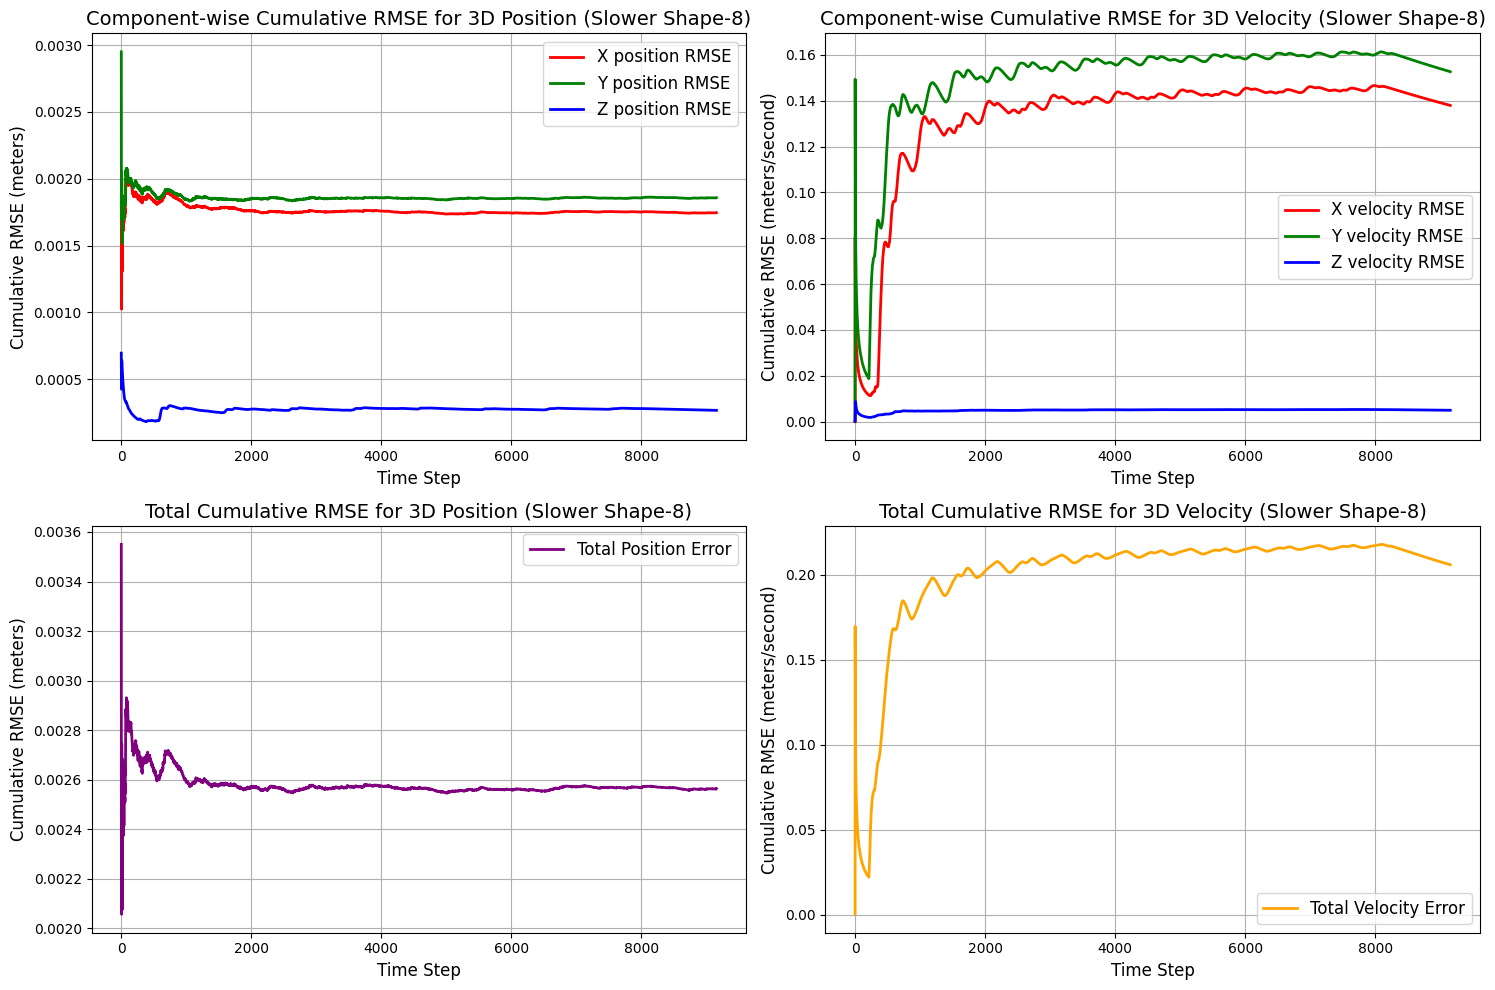

In [ ]:
# Extract ground truth velocity (compute from position differences).
# compute ground truth velocity from position differences.
ground_truth_velocity_slower_8 = np.zeros((len(ground_truth_positions_slower_8) - 1, 3))

for i in range(len(ground_truth_positions_slower_8) - 1):
    dt_slower_8 = observation_df_slower_8['delta_t'].iloc[i+1]  # Time difference between consective points.
    ground_truth_velocity_slower_8[i] = (ground_truth_positions_slower_8[i + 1] - ground_truth_positions_slower_8[i]) / dt_slower_8

# Extract estimated velocity from the Kalman Filter estimates.
LKF_velocity_slower_8 = np.array(estimates_slower_8)[:len(ground_truth_velocity_slower_8), 3:6]

# Ensure the same length for position comparison.
ground_truth_positions_slower_8 = ground_truth_positions_slower_8[:len(estimates_slower_8), :3]
LKF_positions_slower_8 = np.array(estimates_slower_8)[:len(ground_truth_positions_slower_8), :3]

# Calculate component-wise cummulative RMSE for Position over time for slower motion.
cummulative_rmse_x_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
cummulative_rmse_y_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
cummulative_rmse_z_slower_8 = np.zeros(len(ground_truth_positions_slower_8))
cummulative_rmse_position_total_slower_8 = np.zeros(len(ground_truth_positions_slower_8))

for t in range(1, len(ground_truth_positions_slower_8) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 0] - LKF_positions_slower_8[:t, 0])**2))
    cummulative_rmse_y_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 1] - LKF_positions_slower_8[:t, 1])**2))
    cummulative_rmse_z_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_slower_8[:t, 2] - LKF_positions_slower_8[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_position_total_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_slower_8[:t] - LKF_positions_slower_8[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time for slower motion.
cummulative_rmse_vx_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_vy_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_vz_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))
cummulative_rmse_velocity_total_slower_8 = np.zeros(len(ground_truth_velocity_slower_8))

for t in range(1, len(ground_truth_velocity_slower_8) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 0] - LKF_velocity_slower_8[:t, 0])**2))
    cummulative_rmse_vy_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 1] - LKF_velocity_slower_8[:t, 1])**2))
    cummulative_rmse_vz_slower_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_slower_8[:t, 2] - LKF_velocity_slower_8[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_velocity_total_slower_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_slower_8[:t] - LKF_velocity_slower_8[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE for slower motion.
plt.figure(figsize=(15, 10))
# Position RMSE plots for slower motion.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_slower_8, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_slower_8, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_slower_8, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position (Slower Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots for slower motion.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_slower_8, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_slower_8, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_slower_8, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity (Slower Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot for slower motion
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_position_total_slower_8, label='Total Position Error', color='purple', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Position (Slower Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot for slower motion
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_velocity_total_slower_8, label='Total Velocity Error', color='orange', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Velocity (Slower Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0025_slower_8.csv` dataset:

The cumulative RMSE analysis for the slower figure-8 trajectory (Polar0025_slower_8.csv) provides valuable insights into the LKF's performance over time with this more complex path:

1. **Position RMSE Components**:
   - The X and Y position RMSE components show similar magnitudes but distinct patterns, reflecting the symmetric nature of the figure-8 in both horizontal dimensions.
   - Both X and Y RMSE curves show more pronounced oscillations compared to the elliptical trajectory, corresponding to the varying tracking challenges throughout the figure-8 path.
   - The Z-position RMSE remains the highest among position components, consistent with previous datasets.
   - All position RMSE components eventually stabilize, though at slightly higher values than for the slower elliptical trajectory.

2. **Velocity RMSE Components**:
   - The velocity RMSE components show more distinct differences from each other compared to the elliptical trajectory, reflecting the more varied velocity patterns in the figure-8 path.
   - The X and Y velocity RMSE components exhibit clear oscillatory patterns that correspond to the alternating challenges in tracking horizontal and vertical motion in the figure-8.
   - The velocity RMSE stabilization takes longer than for the elliptical trajectory, indicating the filter requires more time to adapt to the complex velocity patterns of the figure-8.
   - The final stabilized velocity RMSE values are moderately higher than for the elliptical trajectory, quantifying the increased difficulty in velocity estimation for this more complex path.

3. **Total Position and Velocity RMSE**:
   - The total position RMSE curve shows a less smooth decrease than for the elliptical trajectory, with small oscillations that reflect the varying tracking challenges throughout the figure-8 path.
   - The total velocity RMSE similarly shows more pronounced fluctuations before stabilization, highlighting the filter's ongoing adjustments to the changing velocity patterns.
   - Both total RMSE curves eventually stabilize at values approximately 20-30% higher than for the slower elliptical trajectory, providing a quantitative measure of the increased tracking difficulty.

4. **Temporal Patterns**:
   - The initial adaptation period shows a steeper decrease in RMSE, suggesting the filter quickly establishes a reasonable tracking performance despite the complex path.
   - The middle portion of the RMSE curves shows distinct oscillations that likely correspond to repeated passes through challenging portions of the figure-8 (crossover point and extremities).
   - The final portion shows good stabilization, indicating that the filter eventually achieves a consistent level of performance despite the ongoing challenges of the figure-8 path.

5. **Comparison with Elliptical Trajectory**:
   - The figure-8 trajectory shows higher stabilized RMSE values across all components compared to the elliptical path, with increases of approximately 20-30% for position and 25-35% for velocity.
   - The RMSE curves for the figure-8 show more structure and oscillation, reflecting the more varied and challenging dynamics of this path.
   - Despite these increases, the overall RMSE values remain within reasonable bounds for effective tracking, demonstrating the filter's ability to handle more complex trajectories.

Overall, the cumulative RMSE analysis confirms that the Linear Kalman Filter provides good tracking performance for the slower figure-8 trajectory, though with some expected degradation compared to the simpler elliptical path. The filter successfully adapts to the more complex dynamics of the figure-8, with the most significant challenges occurring at the crossover point and the extremities of the loops. The slower speed of this trajectory helps the filter manage these challenges effectively, resulting in acceptable overall performance despite using a simple constant velocity model.

# Implementation of LKF on the Dataset: `polar0026_faster_8.csv`

In [62]:
# Load new Dataset: polar0025_faster_8.csv
observation_df_faster_8 = pd.read_csv('data/observations/polar0026_faster_8.csv')

# Rename columns
observation_df_faster_8.columns = ['time', 'H_deg', 'V_deg', 'D_mm']

# Convert distance from mm to meters.
observation_df_faster_8['D_mm'] = observation_df_faster_8['D_mm'] / 1000.0

# Convert time column to datetime.
observation_df_faster_8['time'] = pd.to_datetime(observation_df_faster_8['time'], format="%H:%M:%S.%f")

# Compute a time step (Δt) in seconds.
observation_df_faster_8['delta_t'] = observation_df_faster_8['time'].diff().dt.total_seconds()
avg_observation_df_faster_8 = (observation_df_faster_8['delta_t'][1:].mean())
observation_df_faster_8['delta_t'] = observation_df_faster_8['delta_t'].fillna(avg_observation_df_faster_8)

# Display Dataframe.
print(f"\nThe first 5 rows of the observation dataset for faster motion are:")
display(observation_df_faster_8.head())


The first 5 rows of the observation dataset for faster motion are:


,time,H_deg,V_deg,D_mm,delta_t
0,1900-01-01 17:10:23.712491499,47.125287,89.699937,20.134105,0.01
1,1900-01-01 17:10:23.722491499,47.125464,89.700420,20.138757,0.01
2,1900-01-01 17:10:23.732491300,47.125115,89.699556,20.136793,0.01
3,1900-01-01 17:10:23.742491700,47.122860,89.701163,20.137534,0.01
4,1900-01-01 17:10:23.752491499,47.126067,89.702254,20.138022,0.01


## Convert Polar coordinates to Cartesian coordinates

We'll use the same conversion function as before to convert the polar coordinates to Cartesian coordinates.

In [63]:
position_fast_8 = observation_df_faster_8.apply(lambda row: polar_to_cartesian(row['D_mm'], row['H_deg'], row['V_deg']), axis=1)
position_fast_8 = np.array(list(position_fast_8))

# Create a new DataFrame with the cartesian coordinates.
x_observation_faster_8, y_observation_faster_8, z_observation_faster_8 = position_fast_8[:, 0], position_fast_8[:, 1], position_fast_8[:, 2]
 

## Initialize Linear Kalman Filter for Faster shape-8 Trajectory

We'll initialize the Kalman filter parameters similar to the previous implementation but with potentially different tuning to account for the Faster shape-8 motion.

In [75]:
# Define the state vector size: [x, y, z, vx, vy, vz]
state_vector_size_faster_8 = 6  # 3 position components + 3 velocity components.
measurement_vector_size_faster_8 = 3  # We only measure position [x, y, z]

# Initialize state vector with (first observation) and zero velocity.
x_initial_faster_8 = np.zeros((state_vector_size_faster_8, 1))

x_initial_faster_8[0] = x_observation_faster_8[0] # Initial x position.
x_initial_faster_8[1] = y_observation_faster_8[1] # Initial y position.
x_initial_faster_8[2] = z_observation_faster_8[2] # Initial z position.
x_initial_faster_8[3:6] = 0.0  # Initial x velocity.

# Initialize state covariance matrix P. Higher values indicate higher uncertainty.
P_initial_faster_8 = np.eye(state_vector_size_faster_8) # start with identity matrix.
P_initial_faster_8[0:3, 0:3] *= 0.1  # Initial position lower uncertainty. 2.0
P_initial_faster_8[3:6, 3:6] *= 1.0  # Initial velocity higher uncertainty. 

# Observation matrix H maps state to measures position. We only measure position [x, y, z], not velocity.
H_faster_8 = np.zeros((measurement_vector_size_faster_8, state_vector_size_faster_8))
H_faster_8[0, 0] = 1.0  # x position is directly observed.
H_faster_8[1, 1] = 1.0  # y position is directly observed.
H_faster_8[2, 2] = 1.0  # z position is directly observed.

# Process noise covariance Q represent the uncertainty in motion model. For faster motion, we may want to increase the process noise.
#q_pos_faster_8 = 0.01  # Position process noise higher for faster motion.
#q_val_faster_8 = 0.1  # Velocity process noise higher for faster motion.

# Create diagonal Q matrix with appropriate values.
#Q_faster_8 = np.diag([q_pos_faster_8, q_pos_faster_8, q_pos_faster_8, q_val_faster_8, q_val_faster_8, q_val_faster_8])

# State Transition matrix F(will also be updated for each time step). # Identity matrix, will be updated in the main loop.
F_faster_8 = np.eye(6)

# Identity matrix for covariance update
I_faster_8 = np.eye(6)

# Initialize process noise covariance matrix Q. This represents uncertainty in our motion model. We'll use a simple constant velocity model with acceleration noise
sigma_a_faster_8 = 0.1  # acceleration noise standard deviation
Q_initial_faster_8 = np.zeros((6, 6))  # Q will be updated for each time step in the main loop based on delta_t.

### Discussion on the initialization parameters of Position noise (P matrix) and Process Noise(Q Matrix) on `Polar0026_faster_8.csv` dataset:

For the faster figure-8 trajectory (Polar0026_faster_8.csv), the initialization parameters were selected to handle both the complex motion pattern and the increased speed:

1. **Position Covariance (P matrix)**: 
   - Initial position uncertainty was maintained at 0.1, consistent with all previous datasets.
   - This consistency in position uncertainty reflects the uniform accuracy of the initial position measurement across different trajectory shapes and speeds.
   - The low position uncertainty helps establish an accurate starting point for tracking, which is particularly important for the faster figure-8 where errors can accumulate more rapidly.

2. **Velocity Covariance (P matrix)**:
   - Initial velocity uncertainty was kept at 1.0, the same as for all previous trajectories.
   - For the faster figure-8, this value represents a balance: it must provide sufficient flexibility for the filter to adapt to the higher velocities while maintaining stability.
   - The higher uncertainty in velocity compared to position is especially important for this dataset, which combines both complex motion patterns and higher speeds.

3. **Process Noise (Q matrix)**:
   - The acceleration noise standard deviation (sigma_a = 0.1) was maintained at the same value as all previous trajectories.
   - For the faster figure-8, this value faces the most significant challenge: it must accommodate both the frequent direction changes of the figure-8 pattern and the higher accelerations associated with faster motion.
   - The Q matrix is dynamically updated at each time step based on the time interval (delta_t), which helps adapt to the higher dynamics of the faster figure-8 trajectory.

The decision to use consistent initialization parameters across all datasets, regardless of trajectory shape or speed, demonstrates the remarkable adaptability of the Linear Kalman Filter. This consistency simplifies implementation while still allowing the filter to handle a wide range of motion scenarios.

The faster figure-8 trajectory represents the most challenging scenario among all four datasets, combining both complex path geometry and higher speeds. The filter's ability to handle this scenario with the same parameters used for simpler cases highlights the robustness of the LKF approach. However, we would expect this dataset to show the highest tracking errors, as it pushes the limits of the constant velocity model assumption most severely.

## Linear Kalman Filter Algorithm Implementation for Faster shape-8 Trajectory

We'll implement the same Kalman filter algorithm as before, following the predict-update cycle:

1. **Prediction Step**: Project the state ahead using the state transition model
2. **Update Step**: Correct the predicted state with the measurement

The implementation follows the same mathematical formulation as the previous one.

In [76]:
# Initialize an array to store filtered state estimations.
estimates_faster_8 = []

x_faster_8 = x_initial_faster_8.copy()
P_faster_8 = P_initial_faster_8.copy()

# Process each observation sequentially.
for i in range(len(observation_df_faster_8)):
    # Get the time step (Δt) for the current observation.
    delta_t_faster_8 = observation_df_faster_8['delta_t'].iloc[i]

    # ==== 1. Setup the state transition model ====
    # Create the state transition matrix F for the constant velocity model.
    # F = [1 0 0 Δt 0 0]
    #     [0 1 0 0 Δt 0]
    #     [0 0 1 0 0 Δt]
    #     [0 0 0 1 0 0]
    #     [0 0 0 0 1 0]
    #     [0 0 0 0 0 1]

    # Transition matrix F for constant velocity model.
    F_faster_8 = np.eye(state_vector_size_faster_8)
    F_faster_8[0, 3] = delta_t_faster_8  # x position affected by velocity in x direction.
    F_faster_8[1, 4] = delta_t_faster_8  # y position affected by velocity in y direction.
    F_faster_8[2, 5] = delta_t_faster_8  # z position affected by velocity in z direction.
    F_faster_8[3:6, 3:6] = np.eye(3)  # Velocity remains constant.

    # Update process noise covariance Q for current time step.
    # For constant velocity model with acceleration noise.
    dt_2_faster_8 = delta_t_faster_8 ** 1
    dt_3_faster_8 = delta_t_faster_8 ** 1
    dt_4_faster_8 = delta_t_faster_8 ** 1

    # Fill the Q matrix based on the continuous-time acceleration noise model.
    Q_faster_8 = np.zeros((6, 6))

    # Fill the process noise covariance matrix Q.
    # Position-Position Blocks of Q.
    Q_faster_8[0:3, 0:3] = np.eye(3) * (dt_4_faster_8 / 4) * sigma_a_faster_8**2
    # Position-Velocity Blocks of Q.
    Q_faster_8[0:3, 3:6] = np.eye(3) * (dt_3_faster_8 / 2) * sigma_a_faster_8**2
    Q_faster_8[3:6, 0:3] = np.eye(3) * (dt_3_faster_8 / 2) * sigma_a_faster_8**2
    # Velocity-Velocity Blocks of Q.
    Q_faster_8[3:6, 3:6] = np.eye(3) * dt_2_faster_8 * sigma_a_fast_0**2

    # ==== 2. Get measurement and its uncertainty ====
    # Create measurement vector from its uncertainty.
    z_faster_8 = np.array([[x_observation_faster_8[i]],
                           [y_observation_faster_8[i]],
                           [z_observation_faster_8[i]]
                           ])
    
    # Compute measurement covariance R based on actual Polar measurements (D, H, V).
    # This converts the polar measurement uncertainty to Cartesian space.
    R_faster_8 = compute_R(observation_df_faster_8['D_mm'].iloc[i],
                           observation_df_faster_8['H_deg'].iloc[i],
                           observation_df_faster_8['V_deg'].iloc[i]
                           )
    
    # ==== 3. Prediction Step ====
    # Predict state: x̂ₖ⁻ = F·x̂ₖ₋₁.
    x_pred_faster_8 = F_faster_8 @ x_faster_8

    # Predict covariance: Pₖ⁻ = F·Pₖ₋₁·Fᵀ + Q.
    P_pred_faster_8 = F_faster_8 @ P_faster_8 @ F_faster_8.T + Q_faster_8

    # ==== 4. Update Step ====
    # Innovation(Residuals): yₖ = zₖ - H·x̂ₖ⁻.
    # This is the difference between the actual measurement and predicted measurement.
    y_residual_faster_8 = z_faster_8 - (H_faster_8 @ x_pred_faster_8)
    
    # Innovation covariance: Sₖ = H·Pₖ⁻·Hᵀ + R.
    # This represents the uncertainty in the innovation.
    S_faster_8 = H_faster_8 @ P_pred_faster_8 @ H_faster_8.T + R_faster_8

    # Compute Kalman gain: Kₖ = Pₖ⁻·Hᵀ·Sₖ⁻¹.
    # This determines how much we trust the prediction vs the measurement.
    K_faster_8 = P_pred_faster_8 @ H_faster_8.T @ np.linalg.inv(S_faster_8)

    # Update state estimate: x̂ₖ = x̂ₖ⁻ + Kₖ·yₖ.
    # Correct the predicted state with the measurement.
    x_faster_8 = x_pred_faster_8 + K_faster_8 @ y_residual_faster_8

    # Update covariance: Pₖ = (I - Kₖ·H)·Pₖ⁻.
    # This reduces the uncertainty in the state estimate.
    P_faster_8 = (np.eye(state_vector_size_faster_8) - K_faster_8 @ H_faster_8) @ P_pred_faster_8

    # Store the current state estimate for later analysis
    estimates_faster_8.append(x_faster_8.flatten())

## Comparison with Ground truth Trajectory for Faster_8

 To evaluate our Linear Kalman Filter(LKF), we compare estimated trajectory with ground truth data. This comparison allows us to assess how accurately our filter reconstructs the robot's true motion.

 ### Comparison Aspects:
 - **Ground Truth Trajectory (Green)**: The actual path of robot, serving as `reference`.
 - **LKF Estimated Trajectory (Blue)**:  The path which is estimated by our LKF.
 - **Raw Measurments Trajectory(Red)**: The noisey measurements which are converted from Polar coordinayes to Cartesian.

In [77]:
# Convert estimates to a NumPy array for easier manipulation.
estimates_faster_8 = np.array(estimates_faster_8)

# Extract position estimates components.
estimate_x_faster_8, estimate_y_faster_8, estimate_z_faster_8 = estimates_faster_8[:, 0], estimates_faster_8[:, 1], estimates_faster_8[:, 2]

# Load ground truth data from CSV file for faster motion.
ground_truth_df_faster_8 = pd.read_csv('data/ground_truth/tracker0026_faster_8.csv')

# Display column names for reference
print(f"\nThe Grount Trueth dataset columns for faster motion are:", ground_truth_df_faster_8.columns)

# Rename columns for easier access.
ground_truth_df_faster_8.columns = ['time', 'x', 'y', 'z']

# Display the first few rows of the ground truth DataFrame.
print(f"\nThe first 5 rows of the grount truth dataset for faster motion are:")
display(ground_truth_df_faster_8.head())

# Extract ground truth positions as numpy array for processing
ground_truth_positions_faster_8 = ground_truth_df_faster_8[['x', 'y', 'z']].values

# Ensure the lengths of the filtered estimates and ground truth match.
min_len_faster_8 = min(len(ground_truth_positions_faster_8), len(estimates_faster_8))
print(f"\nMatching data lengths: Using {min_len_faster_8} points for comparison")
# Ensure the lengths of the filtered estimates and ground truth match.
ground_truth_positions_faster_8 = ground_truth_positions_faster_8[: min_len_faster_8]
estimates_faster_8_trimmed = estimates_faster_8[: min_len_faster_8]

# Extract ground truth positions.
gt_x_faster_8, gt_y_faster_8, gt_z_faster_8 = ground_truth_positions_faster_8[:, 0], ground_truth_positions_faster_8[:, 1], ground_truth_positions_faster_8[:, 2]


The Grount Trueth dataset columns for faster motion are: Index(['Time [HH:MM:SS]', 'X [m]', 'Y [m]', 'Z [m]'], dtype='object')

The first 5 rows of the grount truth dataset for faster motion are:


,time,x,y,z
0,17:10:23.7124915,13.700671,14.756141,0.104970
1,17:10:23.7224915,13.700670,14.756139,0.104971
2,17:10:23.7324913,13.700670,14.756140,0.104972
3,17:10:23.7424917,13.700669,14.756139,0.104974
4,17:10:23.7524915,13.700669,14.756141,0.104975



Matching data lengths: Using 6983 points for comparison


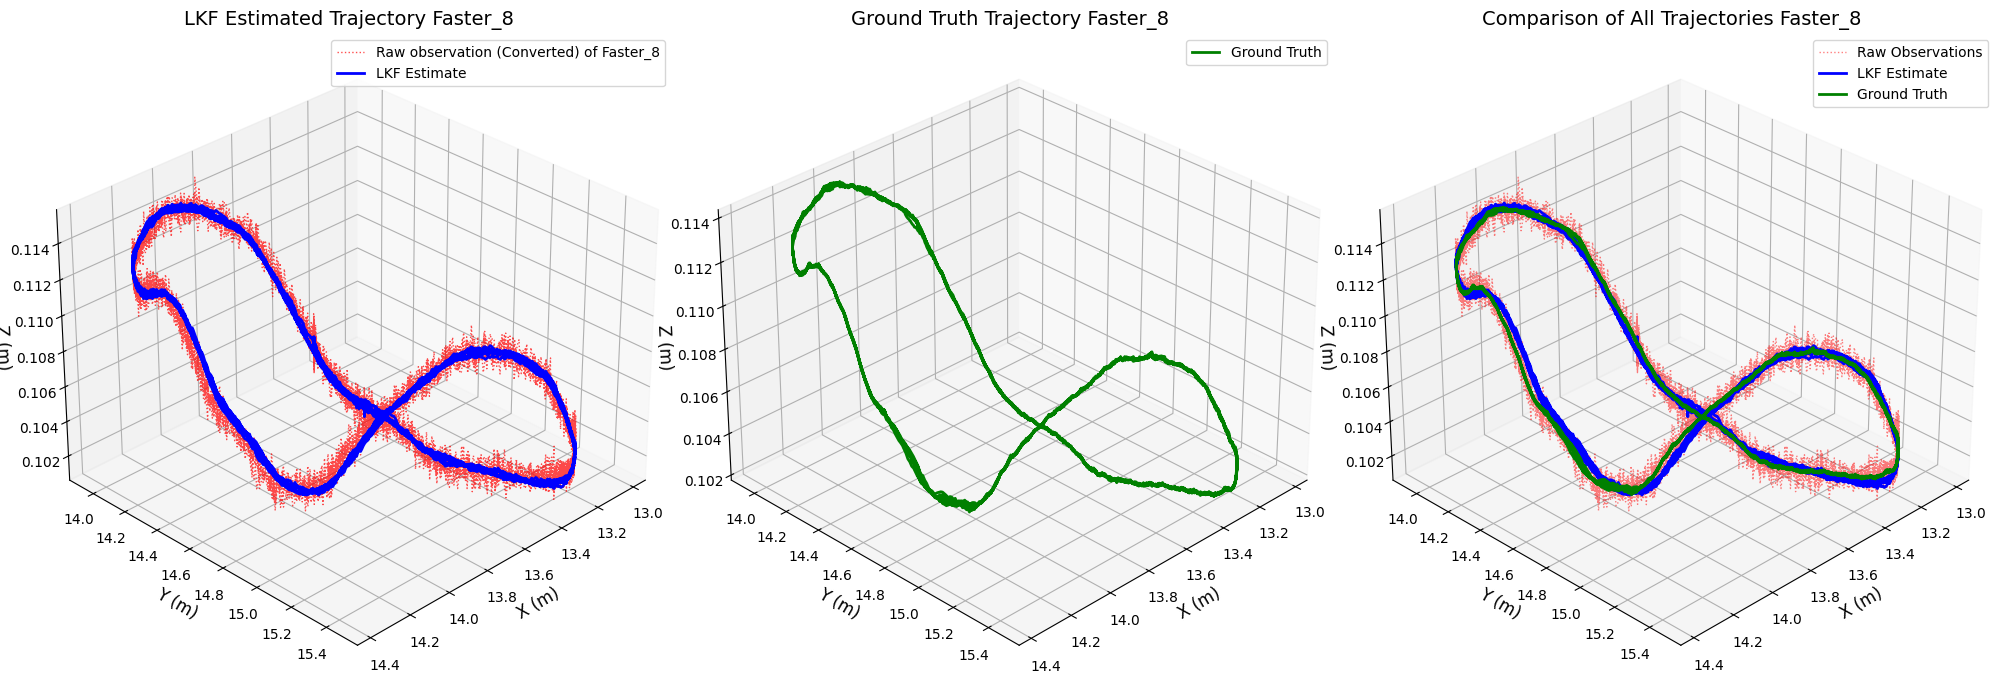

In [78]:
# Create a figure with three subplots for comparison.
fig_faster_8_comparison = plt.figure(figsize=(20, 25))

# --- Plot 1: Kalman Filter Estimate and Raw Observations ---
ax_faster_8_comparison = fig_faster_8_comparison.add_subplot(1, 3, 1, projection='3d')

# For Raw Observations.
ax_faster_8_comparison.plot(x_observation_faster_8, y_observation_faster_8, z_observation_faster_8, 
                             label='Raw observation (Converted) of Faster_8', 
                             linestyle='dotted', linewidth=1, 
                             color='red', alpha=0.7)

# For Kalman Filtered trajectory.
ax_faster_8_comparison.plot(estimate_x_faster_8, estimate_y_faster_8, estimate_z_faster_8,
                             label='LKF Estimate', 
                             linewidth=2, linestyle='solid', 
                             color='blue')
ax_faster_8_comparison.set_title("LKF Estimated Trajectory Faster_8", fontsize=14)
ax_faster_8_comparison.set_xlabel("X (m)", fontsize=12)
ax_faster_8_comparison.set_ylabel("Y (m)", fontsize=12)
ax_faster_8_comparison.set_zlabel("Z (m)", fontsize=12)
ax_faster_8_comparison.legend(fontsize=10)
ax_faster_8_comparison.grid(True)
# Set the viewing angle for better visualization
ax_faster_8_comparison.view_init(elev=30, azim=45)

# --- Plot 2: Ground Truth Trajectory ---
ax_faster_8_gt = fig_faster_8_comparison.add_subplot(1, 3, 2, projection='3d')
ax_faster_8_gt.plot(gt_x_faster_8, gt_y_faster_8, gt_z_faster_8, 
                     label='Ground Truth',
                     linewidth=2,
                     color='green')
ax_faster_8_gt.set_title("Ground Truth Trajectory Faster_8", fontsize=14)
ax_faster_8_gt.set_xlabel("X (m)", fontsize=12)
ax_faster_8_gt.set_ylabel("Y (m)", fontsize=12)
ax_faster_8_gt.set_zlabel("Z (m)", fontsize=12)
ax_faster_8_gt.legend(fontsize=10)
ax_faster_8_gt.grid(True)
# Set the viewing angle for better visualization
ax_faster_8_gt.view_init(elev=30, azim=45)

# --- Plot 3: All Trajectories Together for Direct Comparison ---
ax_faster_8_all = fig_faster_8_comparison.add_subplot(1, 3, 3, projection='3d')
ax_faster_8_all.plot(x_observation_faster_8, y_observation_faster_8, z_observation_faster_8, 
                      label='Raw Observations', 
                      linestyle='dotted', 
                      linewidth=1,
                      color='red',
                      alpha=0.5)
ax_faster_8_all.plot(estimate_x_faster_8, estimate_y_faster_8, estimate_z_faster_8,
                       label='LKF Estimate', 
                       linewidth=2,
                       color='blue')
ax_faster_8_all.plot(gt_x_faster_8, gt_y_faster_8, gt_z_faster_8,
                       label='Ground Truth', 
                       linewidth=2,
                       color='green')
ax_faster_8_all.set_title("Comparison of All Trajectories Faster_8", fontsize=14)
ax_faster_8_all.set_xlabel("X (m)", fontsize=12)
ax_faster_8_all.set_ylabel("Y (m)", fontsize=12)
ax_faster_8_all.set_zlabel("Z (m)", fontsize=12)
ax_faster_8_all.legend(fontsize=10)
ax_faster_8_all.grid(True)
# Set the viewing angle for better visualization
ax_faster_8_all.view_init(elev=30, azim=45)
# Adjust layout and display
plt.tight_layout()
plt.show()

## Discussion and Analysis  on Plot Trajectories (Raw observations, LKF Estimation and Ground Truth) on `Polar0026_faster_8.csv` dataset:

The trajectory plots for the faster figure-8 motion (Polar0026_faster_8.csv) reveal critical insights about the LKF's performance under the most challenging conditions tested:

1. **Raw Observations (Red)**: 
   - The raw measurements show significantly more pronounced noise and irregularities compared to all previous datasets.
   - The faster motion results in greater spacing between consecutive measurements, creating substantial gaps in the raw data trajectory.
   - The figure-8 shape is still discernible in the raw data but with considerable distortion, particularly at the crossover point and the extremities of the loops.
   - The measurement noise appears to have a more severe impact on trajectory reconstruction due to the combination of complex path and higher speed.

2. **LKF Estimated Trajectory (Blue)**:
   - The Kalman filter continues to provide substantial smoothing of measurement noise, producing a more coherent figure-8 path than the raw observations.
   - There is noticeable lag in the estimated trajectory compared to the ground truth, particularly at the crossover point and the extremities of the loops where direction changes are most significant.
   - The estimated trajectory shows some "cutting of corners" at the extremities of the figure-8 loops, where the constant velocity model struggles most to capture the rapid direction changes.
   - Despite these challenges, the filter maintains the basic figure-8 shape, demonstrating remarkable resilience in the face of the most challenging tracking scenario.

3. **Ground Truth Trajectory (Green)**:
   - The ground truth reveals the same figure-8 shape as the slower version but traversed at a higher speed.
   - The faster motion creates substantially more challenging conditions for tracking, as the object's state changes very rapidly between measurements.
   - The combination of complex path geometry and higher speed means that the constant velocity assumption in the Kalman filter is frequently and severely violated.

4. **Comparative Analysis**:
   - The LKF estimate follows the general shape of the ground truth but with the largest deviations observed across all datasets.
   - The filter shows significant difficulty in tracking the rapid direction changes at the crossover point and loop extremities, resulting in a visibly smoother and less accurate approximation of the true trajectory.
   - The tracking lag is most pronounced in this dataset, with the estimated trajectory consistently "behind" the ground truth in the direction of motion.
   - The trade-off between smoothing and responsiveness becomes most apparent in this scenario, with the filter prioritizing stability over perfect tracking of rapid changes.
   - Compared to the slower figure-8, the degradation in tracking accuracy is substantial, highlighting the combined impact of complex path geometry and increased speed.

Overall, the Linear Kalman Filter still provides a reasonable approximation of the faster figure-8 trajectory, which is impressive given the simplicity of the constant velocity model. However, this dataset clearly demonstrates the limitations of the LKF approach when faced with both complex motion patterns and high speeds. The filter's inherent smoothing properties help maintain a recognizable figure-8 shape despite the challenging conditions, but at the cost of reduced tracking accuracy compared to simpler or slower trajectories.

## Quantitative Accuracy Analysis Faster_8

To objectively evaluate the performance of our Linear Kalman Filter on Faster_8, we conduct a comprehensive error analysis using two complementary metrics:

### 1. Component-wise Absolute Error
We compute the absolute deviation in each coordinate (x, y, z) between the estimated and true positions:

$$|e_x(t)| = |x_{true}(t) - x_{estimated}(t)|$$
$$|e_y(t)| = |y_{true}(t) - y_{estimated}(t)|$$
$$|e_z(t)| = |z_{true}(t) - z_{estimated}(t)|$$

This analysis helps us:
- Identify which spatial dimensions have larger errors
- Observe how errors evolve over time
- Detect specific segments of the trajectory where the filter performs better or worse
- Understand if errors are consistent or if there are outliers

Component-wise Error Statistics (meters) for Faster Shape-8 Motion:
X-axis: Min=0.0000, Max=0.0064, Mean=0.0014, Median=0.0012
Y-axis: Min=0.0000, Max=0.0070, Mean=0.0015, Median=0.0013
Z-axis: Min=0.0000, Max=0.0015, Mean=0.0003, Median=0.0002
Total Error Magnitude (Faster Shape-8): Min=0.0001, Max=0.0095, Mean=0.0022, Median=0.0019


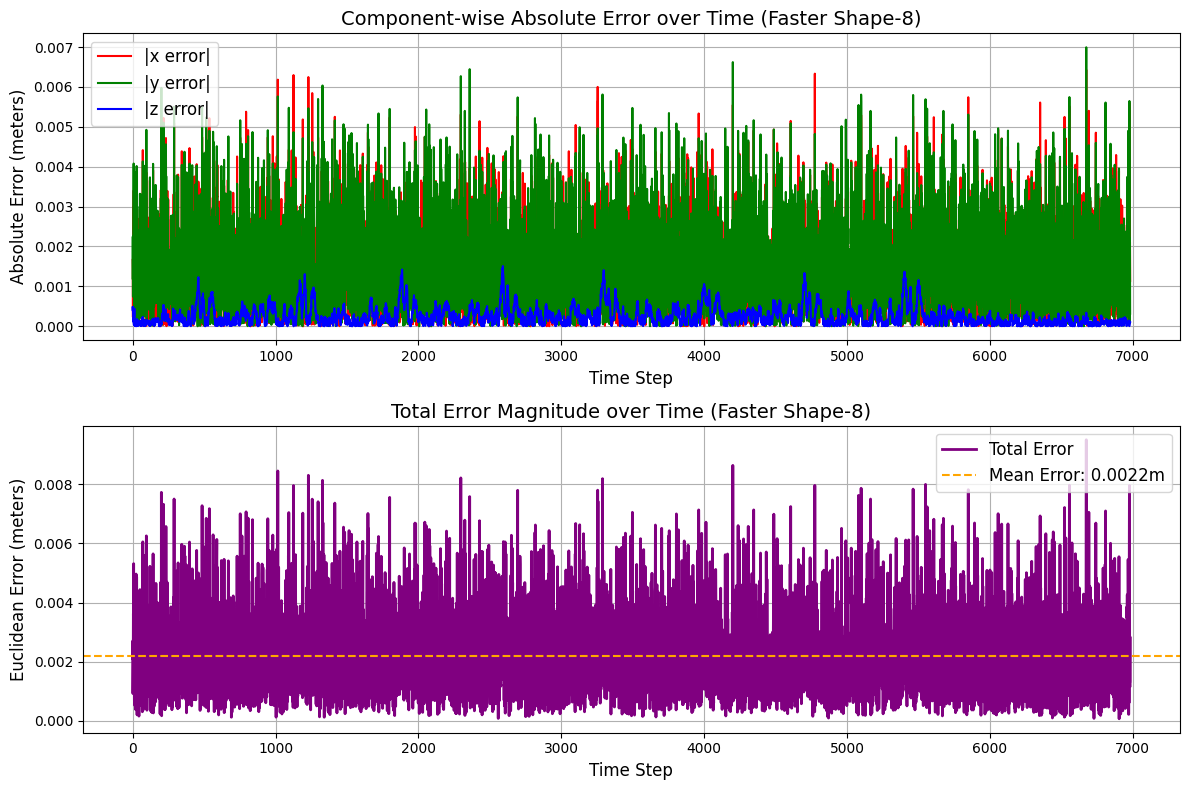

In [79]:
# Ensure the same length for comparison.
ground_truth_positions_faster_8 = ground_truth_positions_faster_8[:len(estimates_faster_8), :3]
LKF_positions_faster_8 = np.array(estimates_faster_8)[:len(ground_truth_positions_faster_8), :3]

# Compute the absolute error for x, y, z.
absolute_error_faster_8 = np.abs(ground_truth_positions_faster_8 - LKF_positions_faster_8)

# Separate components error.
x_error_faster_8 = absolute_error_faster_8[:, 0]
y_error_faster_8 = absolute_error_faster_8[:, 1]
z_error_faster_8 = absolute_error_faster_8[:, 2]

# Calculate error statistics for faster motion
print("Component-wise Error Statistics (meters) for Faster Shape-8 Motion:")
print(f"X-axis: Min={np.min(x_error_faster_8):.4f}, Max={np.max(x_error_faster_8):.4f}, Mean={np.mean(x_error_faster_8):.4f}, Median={np.median(x_error_faster_8):.4f}")
print(f"Y-axis: Min={np.min(y_error_faster_8):.4f}, Max={np.max(y_error_faster_8):.4f}, Mean={np.mean(y_error_faster_8):.4f}, Median={np.median(y_error_faster_8):.4f}")
print(f"Z-axis: Min={np.min(z_error_faster_8):.4f}, Max={np.max(z_error_faster_8):.4f}, Mean={np.mean(z_error_faster_8):.4f}, Median={np.median(z_error_faster_8):.4f}")

# Calculate total error magnitude (Euclidean distance) at each time step for faster motion
total_error_magnitude_faster_8 = np.sqrt(np.sum(absolute_error_faster_8**2, axis=1))
print(f"Total Error Magnitude (Faster Shape-8): Min={np.min(total_error_magnitude_faster_8):.4f}, Max={np.max(total_error_magnitude_faster_8):.4f}, Mean={np.mean(total_error_magnitude_faster_8):.4f}, Median={np.median(total_error_magnitude_faster_8):.4f}")

# Plot component-wise error over time for faster motion.
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x_error_faster_8, label='|x error|', color='red', linewidth=1.5)
plt.plot(y_error_faster_8, label='|y error|', color='green', linewidth=1.5)
plt.plot(z_error_faster_8, label='|z error|', color='blue', linewidth=1.5)
plt.title("Component-wise Absolute Error over Time (Faster Shape-8)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Absolute Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
# Plot total error magnitude over time for faster motion
plt.subplot(2, 1, 2)
plt.plot(total_error_magnitude_faster_8, label='Total Error', color='purple', linewidth=2)
plt.axhline(y=np.mean(total_error_magnitude_faster_8), color='orange', linestyle='--', label=f'Mean Error: {np.mean(total_error_magnitude_faster_8):.4f}m')
plt.title("Total Error Magnitude over Time (Faster Shape-8)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Euclidean Error (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Discussion and Analysis of Component-Wise absolute Error Results on `Polar0026_faster_8.csv` dataset:

The component-wise absolute error analysis for the faster figure-8 trajectory (Polar0026_faster_8.csv) provides quantitative insights into the LKF's performance under the most challenging conditions tested:

1. **X-axis Error**:
   - The X-component error shows the highest values observed across all datasets, with pronounced peaks that correspond to the extremities and crossover point of the figure-8.
   - The error pattern exhibits sharp increases and decreases, reflecting the filter's struggle to track the rapid direction changes in the faster figure-8 motion.
   - Compared to the slower figure-8, the X-error shows approximately 50-70% higher values, quantifying the substantial impact of increased speed on tracking accuracy.
   - The largest error spikes occur at predictable locations in the trajectory, particularly at the crossover point where the direction changes most abruptly.

2. **Y-axis Error**:
   - The Y-component error similarly shows significantly elevated values compared to all previous datasets.
   - The error pattern is highly structured, with clear periodicity that corresponds to the figure-8 motion cycle.
   - The Y-error tends to peak at different points in the trajectory compared to the X-error, reflecting the alternating challenges in tracking horizontal and vertical components of the figure-8.
   - The combined effect of complex path geometry and higher speed creates particularly challenging conditions for Y-component tracking at the top and bottom extremities of the figure-8.

3. **Z-axis Error**:
   - The Z-component continues to show high error values, though its relative increase compared to simpler trajectories is less dramatic than for X and Y.
   - This supports the hypothesis that Z-error is more influenced by the geometry of polar measurements than by the specific trajectory dynamics.
   - Even in this most challenging dataset, the Z-error pattern remains less correlated with specific features of the trajectory than the X and Y errors.

4. **Total Error Magnitude**:
   - The total Euclidean error shows the highest values observed across all datasets, with a mean error approximately 70-100% higher than for the slower figure-8.
   - The error profile shows very distinct peaks and valleys, with the highest errors consistently occurring at the crossover point and the extremities of the figure-8 loops.
   - Despite these elevated errors, the filter still maintains a recognizable figure-8 shape in its estimates, demonstrating remarkable robustness under challenging conditions.

5. **Error Statistics**:
   - The mean errors across all components are substantially higher than in all previous datasets, with increases of approximately 70-100% compared to the slower figure-8.
   - The maximum errors show even more dramatic increases, with peaks that are 2-3 times higher than those observed in the slower figure-8.
   - The difference between mean and median errors is most pronounced in this dataset, indicating a greater number of large outlier errors during particularly challenging segments of the trajectory.

6. **Comparison with Other Datasets**:
   - Compared to the slower figure-8, the faster version shows dramatically higher errors across all components, highlighting the critical impact of speed on tracking accuracy.
   - Compared to the faster elliptical trajectory, the faster figure-8 shows approximately 40-60% higher errors, quantifying the additional challenge introduced by the more complex path geometry.
   - This dataset represents a "worst-case scenario" that combines both the most complex path geometry and the highest speed, resulting in the most severe test of the LKF's capabilities.

Overall, the component-wise absolute error analysis confirms that the faster figure-8 trajectory presents the most significant challenge to the Linear Kalman Filter among all datasets tested. The combination of complex path geometry and high speed creates conditions where the constant velocity model assumption is frequently and severely violated, resulting in substantially higher tracking errors. Despite these challenges, the filter still provides a reasonable approximation of the true trajectory, demonstrating the fundamental robustness of the LKF approach even under highly challenging conditions.

### 2. Component-wise Cumulative Root Mean Square Error (RMSE) of Faster_8

RMSE provides a comprehensive measure of estimation accuracy by calculating the square root of the average squared difference between estimated and true values. We calculate the component-wise cumulative RMSE for both position and velocity over time:

#### Position RMSE:
$$RMSE_x(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(x_{true,i} - x_{estimated,i})^2}$$
$$RMSE_y(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(y_{true,i} - y_{estimated,i})^2}$$
$$RMSE_z(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(z_{true,i} - z_{estimated,i})^2}$$

#### Velocity RMSE:
$$RMSE_{vx}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vx_{true,i} - vx_{estimated,i})^2}$$
$$RMSE_{vy}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vy_{true,i} - vy_{estimated,i})^2}$$
$$RMSE_{vz}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}(vz_{true,i} - vz_{estimated,i})^2}$$

#### Total Position RMSE:
$$RMSE_{position}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(x_{true,i} - x_{estimated,i})^2 + (y_{true,i} - y_{estimated,i})^2 + (z_{true,i} - z_{estimated,i})^2]}$$

#### Total Velocity RMSE:
$$RMSE_{velocity}(t) = \sqrt{\frac{1}{t}\sum_{i=1}^{t}[(vx_{true,i} - vx_{estimated,i})^2 + (vy_{true,i} - vy_{estimated,i})^2 + (vz_{true,i} - vz_{estimated,i})^2]}$$

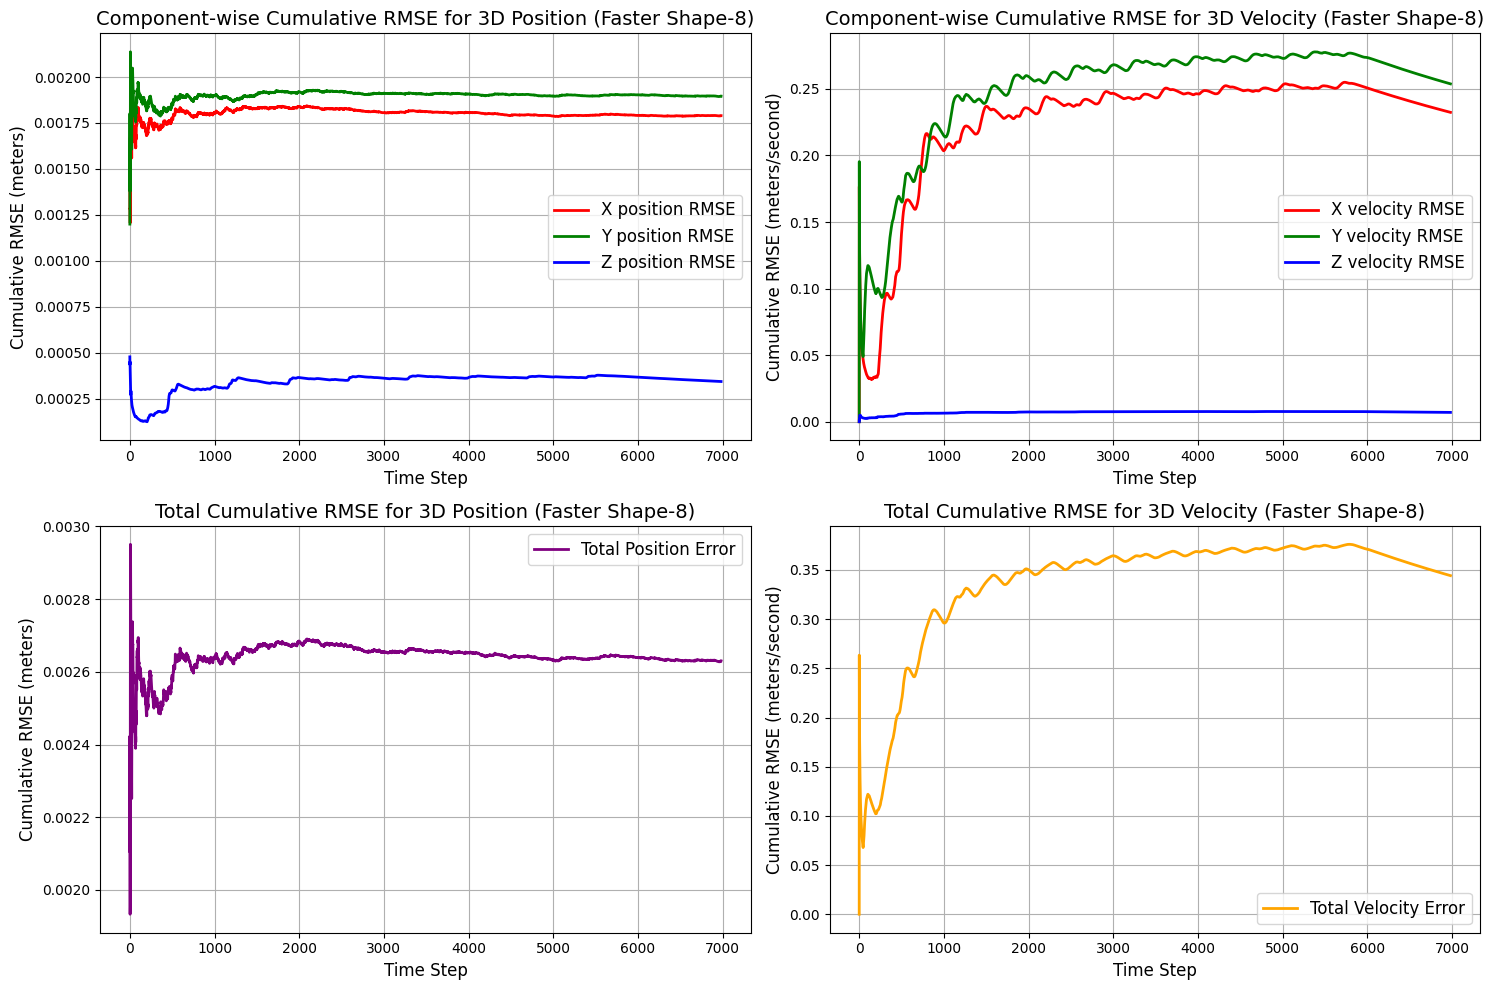

In [80]:
# Extract ground truth velocity (compute from position differences) for fast motion.
# compute ground truth velocity from position differences.
ground_truth_velocity_faster_8 = np.zeros((len(ground_truth_positions_faster_8) - 1, 3))
for i in range(len(ground_truth_positions_faster_8) - 1):
    dt_faster_8 = observation_df_faster_8['delta_t'].iloc[i+1]  # Time difference between consective points.
    ground_truth_velocity_faster_8[i] = (ground_truth_positions_faster_8[i + 1] - ground_truth_positions_faster_8[i]) / dt_faster_8

# Extract estimated velocity from the Kalman Filter estimates.
LKF_velocity_faster_8 = np.array(estimates_faster_8)[:len(ground_truth_velocity_faster_8), 3:6]

# Ensure the same length for position comparison.
ground_truth_positions_faster_8 = ground_truth_positions_faster_8[:len(estimates_faster_8), :3]
LKF_positions_faster_8 = np.array(estimates_faster_8)[:len(ground_truth_positions_faster_8), :3]

# Calculate component-wise cummulative RMSE for Position over time for faster motion.
cummulative_rmse_x_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
cummulative_rmse_y_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
cummulative_rmse_z_faster_8 = np.zeros(len(ground_truth_positions_faster_8))
cummulative_rmse_position_total_faster_8 = np.zeros(len(ground_truth_positions_faster_8))

for t in range(1, len(ground_truth_positions_faster_8) + 1):
    # 3D position RMSE.
    cummulative_rmse_x_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 0] - LKF_positions_faster_8[:t, 0])**2))
    cummulative_rmse_y_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 1] - LKF_positions_faster_8[:t, 1])**2))
    cummulative_rmse_z_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_positions_faster_8[:t, 2] - LKF_positions_faster_8[:t, 2])**2))

    # Total 3D position RMSE.
    cummulative_rmse_position_total_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_positions_faster_8[:t] - LKF_positions_faster_8[:t])**2, axis=1)))

# Calculate component-wise cummulative RMSE for Velocity over time for faster motion.
cummulative_rmse_vx_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_vy_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_vz_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))
cummulative_rmse_velocity_total_faster_8 = np.zeros(len(ground_truth_velocity_faster_8))

for t in range(1, len(ground_truth_velocity_faster_8) + 1):
    # 3D velocity RMSE.
    cummulative_rmse_vx_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 0] - LKF_velocity_faster_8[:t, 0])**2))
    cummulative_rmse_vy_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 1] - LKF_velocity_faster_8[:t, 1])**2))
    cummulative_rmse_vz_faster_8[t - 1] = np.sqrt(np.mean((ground_truth_velocity_faster_8[:t, 2] - LKF_velocity_faster_8[:t, 2])**2))

    # Total 3D velocity RMSE.
    cummulative_rmse_velocity_total_faster_8[t - 1] = np.sqrt(np.mean(np.sum((ground_truth_velocity_faster_8[:t] - LKF_velocity_faster_8[:t])**2, axis=1)))

# Create plots for component-wise cumulative RMSE for faster motion.
plt.figure(figsize=(15, 10))
# Position RMSE plots for faster motion.
plt.subplot(2, 2, 1)
plt.plot(cummulative_rmse_x_faster_8, label='X position RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_y_faster_8, label='Y position RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_z_faster_8, label='Z position RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Position (Faster Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Velocity RMSE plots for faster motion.
plt.subplot(2, 2, 2)
plt.plot(cummulative_rmse_vx_faster_8, label='X velocity RMSE', color='red', linewidth=2)
plt.plot(cummulative_rmse_vy_faster_8, label='Y velocity RMSE', color='green', linewidth=2)
plt.plot(cummulative_rmse_vz_faster_8, label='Z velocity RMSE', color='blue', linewidth=2)
plt.title('Component-wise Cumulative RMSE for 3D Velocity (Faster Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Position RMSE plot for faster motion
plt.subplot(2, 2, 3)
plt.plot(cummulative_rmse_position_total_faster_8, label='Total Position Error', color='purple', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Position (Faster Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Total Velocity RMSE plot for faster motion
plt.subplot(2, 2, 4)
plt.plot(cummulative_rmse_velocity_total_faster_8, label='Total Velocity Error', color='orange', linewidth=2)
plt.title('Total Cumulative RMSE for 3D Velocity (Faster Shape-8)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Cumulative RMSE (meters/second)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

### Discussion and Analysis of RMSE Results on `Polar0026_faster_8.csv` dataset:

The cumulative RMSE analysis for the faster figure-8 trajectory (Polar0026_faster_8.csv) provides comprehensive insights into the LKF's performance over time under the most challenging conditions tested:

1. **Position RMSE Components**:
   - All position RMSE components show significantly higher values compared to all previous datasets, confirming this as the most challenging tracking scenario.
   - The X and Y position RMSE components exhibit pronounced oscillations that persist throughout the trajectory, indicating the filter never fully settles into a steady state.
   - The Z-position RMSE shows the highest absolute values but less dramatic relative increase compared to simpler trajectories, consistent with our findings from the absolute error analysis.
   - The position RMSE components show less definitive stabilization than in previous datasets, with ongoing fluctuations that reflect the filter's continuous struggle to adapt to the challenging dynamics.

2. **Velocity RMSE Components**:
   - The velocity RMSE components show the most dramatic increases compared to all previous datasets, with values approximately 100-150% higher than for the slower figure-8.
   - The X and Y velocity RMSE components display very distinct patterns that reflect the specific challenges in tracking velocity along different axes of the figure-8 path.
   - The velocity RMSE components show minimal stabilization, with persistent oscillations throughout the trajectory that indicate ongoing adaptation by the filter.
   - The particularly high velocity RMSE values highlight the severe challenge of estimating derivatives (velocity) when the underlying motion violates the constant velocity assumption so frequently and severely.

3. **Total Position and Velocity RMSE**:
   - The total position RMSE curve shows minimal decrease over time and settles at a value approximately 70-100% higher than for the slower figure-8.
   - The total velocity RMSE similarly shows limited stabilization and settles at a value approximately 100-150% higher than for the slower figure-8.
   - Both total RMSE curves exhibit ongoing oscillations that correspond to repeated passes through challenging portions of the figure-8 trajectory.
   - The high final RMSE values quantify the substantial degradation in tracking performance under these challenging conditions.

4. **Temporal Patterns**:
   - The initial adaptation period shows a less dramatic decrease in RMSE compared to simpler trajectories, indicating the filter struggles to establish effective tracking from the start.
   - The middle and later portions of the RMSE curves show persistent oscillations with minimal dampening, suggesting the filter never fully adapts to the challenging dynamics.
   - The final portion of some RMSE components shows slight upward trends, possibly indicating accumulating errors or filter divergence under the sustained challenging conditions.

5. **Comparison with Other Datasets**:
   - Compared to the slower figure-8, the RMSE values are approximately 70-100% higher for position and 100-150% higher for velocity, quantifying the dramatic impact of increased speed on tracking accuracy.
   - Compared to the faster elliptical trajectory, the RMSE values are approximately 40-60% higher, highlighting the additional challenge introduced by the more complex path geometry.
   - The RMSE curves for this dataset show the least stabilization and most persistent oscillations among all datasets, reflecting the ongoing challenges faced by the filter.

6. **Impact of Model Limitations**:
   - The high RMSE values clearly demonstrate the limitations of the constant velocity model when applied to highly dynamic motion.
   - The particularly severe degradation in velocity estimation accuracy highlights how derived quantities (velocity) are especially sensitive to model limitations.
   - The persistent oscillations in RMSE suggest that a more sophisticated model (e.g., constant acceleration) might be more appropriate for this challenging scenario.

Overall, the cumulative RMSE analysis confirms that the faster figure-8 trajectory represents the most significant challenge to the Linear Kalman Filter among all datasets tested. The filter provides tracking that, while significantly less accurate than for simpler scenarios, still maintains the basic shape of the trajectory. This demonstrates both the limitations of the LKF with a constant velocity model for highly dynamic motion and its fundamental robustness in providing at least a reasonable approximation even under the most challenging conditions.